In [2]:
%pip install --upgrade pip
%pip install gseapy matplotlib


Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 14.6 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
# --- Robust load + DE fallback + Enrichr/LINCS enrichment per cluster ---

from pathlib import Path
import os
import scanpy as sc
import pandas as pd
import gseapy as gp
import requests  # for a gentle online check

# 0) Normalize working dir to the repo root (folder containing data/processed)
here = Path.cwd()
repo = next((p for p in [here] + list(here.parents) if (p/"data/processed").exists()), None)
assert repo is not None, "Could not find 'data/processed/'. Start from the repo root."
os.chdir(repo)
print("Working dir:", Path.cwd())

PROC = Path("data/processed")
TABLES = Path("results/tables"); TABLES.mkdir(parents=True, exist_ok=True)
OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

# 1) Find the latest processed AnnData
cands = sorted(PROC.glob("ssc_skin_scvi*.h5ad"), key=lambda p: p.stat().st_mtime, reverse=True)
assert cands, (
    "No processed scVI files found in data/processed/. "
    "Run `python src/modeling.py` (or earlier notebook steps) to create one."
)
adata_path = cands[0]
print("Using AnnData:", adata_path)
adata = sc.read_h5ad(adata_path)

# 2) Load DE table or compute if missing
de_csv = TABLES / "rank_genes_groups_leiden_wilcoxon.csv"
if de_csv.exists():
    df = pd.read_csv(de_csv)
    print("Loaded DE:", de_csv)
else:
    assert "leiden" in adata.obs, "Missing 'leiden' clusters. Run clustering before enrichment."
    sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", use_raw=False)
    df = sc.get.rank_genes_groups_df(adata, group=None)
    df.to_csv(de_csv, index=False)
    print("[saved]", de_csv)

# 3) Map Ensembl IDs → symbols if needed (uses adata.var['gene_symbol'] when available)
name_col = "names"
if df[name_col].astype(str).str.startswith(("ENSG", "ENST")).mean() > 0.8 and "gene_symbol" in adata.var.columns:
    # strip version suffixes in both df and var_names (e.g., ENSG00000123.7)
    df_ids   = df[name_col].astype(str).str.replace(r"\.\d+$", "", regex=True)
    var_ids  = pd.Index(adata.var_names.astype(str).str.replace(r"\.\d+$", "", regex=True))
    symbols  = adata.var["gene_symbol"].astype(str)
    # build mapping directly from var_names → gene_symbol
    ens_to_sym = pd.Series(symbols.values, index=var_ids)
    df["symbol"] = df_ids.map(ens_to_sym).fillna(df[name_col])
    name_col = "symbol"

# 4) Enrichr / LINCS per cluster
libs = [
    "GO_Biological_Process_2023",
    "Reactome_2022",
    "KEGG_2021_Human",
    "LINCS_L1000_Chem_Pert_up",
    "LINCS_L1000_Chem_Pert_down",
]

def enrich_and_save(glist, outdir, label):
    if not glist:
        print(f"[skip] {label}: no genes")
        return None
    outdir.mkdir(parents=True, exist_ok=True)

    # optional: gentle online check to fail fast if offline
    try:
        requests.get("https://maayanlab.cloud/Enrichr", timeout=5)
    except Exception:
        print(f"[warn] {label}: Enrichr endpoint not reachable; skipping.")
        return None
    try:
        enr = gp.enrichr(
            gene_list=glist,
            organism="Human",
            gene_sets=libs,
            cutoff=0.05,
            no_plot=True,
            outdir=str(outdir),  # gseapy will also drop its own TSVs here
        )
    except Exception as e:
        print(f"[warn] enrichr failed for {label}: {e}")
        return None
    res = getattr(enr, "results", getattr(enr, "res2d", None))
    if res is not None and not res.empty:
        out_csv = outdir / f"enrichr_{label}.csv"
        res.to_csv(out_csv, index=False)
        print("[saved]", out_csv)
    else:
        print(f"[skip] {label}: no significant terms")
    return res

groups = sorted(map(str, df["group"].unique()), key=lambda x: int(x) if x.isdigit() else x)
for g in groups:
    dfg = df[df["group"].astype(str) == g].copy()

    # filter for significance if present (fallback to 'pvals')
    pcol = "pvals_adj" if "pvals_adj" in dfg.columns else ("pvals" if "pvals" in dfg.columns else None)
    if pcol is not None:
        dfg = dfg[dfg[pcol] < 0.05]
    # split up/down by logFC if available; else just take top by score
    if "logfoldchanges" in dfg.columns:
        up   = (dfg[dfg["logfoldchanges"] > 0]
                .sort_values("logfoldchanges", ascending=False)[name_col]
                .dropna().astype(str).head(200).tolist())
        down = (dfg[dfg["logfoldchanges"] < 0]
                .sort_values("logfoldchanges", ascending=True )[name_col]
                .dropna().astype(str).head(200).tolist())
    else:
        up   = (dfg.sort_values("scores", ascending=False)[name_col]
                .dropna().astype(str).drop_duplicates().head(200).tolist())
        down = []

    base = OUT / f"leiden_{g}"
    enrich_and_save(up,   base / "up",   f"leiden{g}_up")
    enrich_and_save(down, base / "down", f"leiden{g}_down")


Working dir: /home/glen/scleroderma-scvi
Using AnnData: data/processed/ssc_skin_scvi_annot_curated.h5ad
Loaded DE: results/tables/rank_genes_groups_leiden_wilcoxon.csv
[saved] results/drug_repurposing/leiden_0/up/enrichr_leiden0_up.csv
[saved] results/drug_repurposing/leiden_0/down/enrichr_leiden0_down.csv
[saved] results/drug_repurposing/leiden_1/up/enrichr_leiden1_up.csv
[saved] results/drug_repurposing/leiden_1/down/enrichr_leiden1_down.csv
[saved] results/drug_repurposing/leiden_2/up/enrichr_leiden2_up.csv
[saved] results/drug_repurposing/leiden_2/down/enrichr_leiden2_down.csv
[saved] results/drug_repurposing/leiden_3/up/enrichr_leiden3_up.csv
[saved] results/drug_repurposing/leiden_3/down/enrichr_leiden3_down.csv
[saved] results/drug_repurposing/leiden_4/up/enrichr_leiden4_up.csv
[saved] results/drug_repurposing/leiden_4/down/enrichr_leiden4_down.csv
[saved] results/drug_repurposing/leiden_5/up/enrichr_leiden5_up.csv
[saved] results/drug_repurposing/leiden_5/down/enrichr_leiden5_d

In [12]:
# --- 5) Aggregate LINCS hits and compute a reversal score per compound/cluster ---

import re, math, numpy as np, pandas as pd
from pathlib import Path

BASE = Path("results/drug_repurposing")

def _first_col(df, names):
    """Pick the first existing column from a list of candidates (case-insensitive)."""
    lower = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in lower:
            return lower[n.lower()]
    raise KeyError(f"None of columns {names} found in: {list(df.columns)}")

def _clean_compound(term: str) -> str:
    """Heuristic to extract a readable compound name from a LINCS term."""
    t = str(term)
    # common patterns: "drug_XYZ_up", "drug_24h_DN", etc.
    t = t.replace("|", " ").replace(";", " ")
    t = re.split(r"[_\[]", t)[0]   # keep left part before "_" or "["
    t = re.sub(r"\s*\(.*?\)\s*$", "", t)  # drop trailing parens
    return t.strip()

def _signed_reversal_score(row, src: str) -> float:
    """
    + For cluster UP genes vs LINCS 'Chem_Pert_down' => beneficial (+)
    + For cluster DOWN genes vs LINCS 'Chem_Pert_up' => beneficial (+)
    - Opposite pairings => negative
    Score = sign * (-log10(adj_p))
    """
    lib = str(row["library"]).lower()
    # choose adjusted p-value column robustly
    adjp = row["adj_p"]
    if pd.isna(adjp) or adjp <= 0:
        adjp = 1.0  # neutral if missing/bad
    score = -math.log10(adjp)

    sign = 0
    if src == "up":
        if "chem_pert_down" in lib:
            sign = +1
        elif "chem_pert_up" in lib:
            sign = -1
    elif src == "down":
        if "chem_pert_up" in lib:
            sign = +1
        elif "chem_pert_down" in lib:
            sign = -1
    return sign * score

# Collect all per-cluster CSVs we just wrote
records = []
for clus_dir in sorted(BASE.glob("leiden_*")):
    if not clus_dir.is_dir():
        continue
    cluster = clus_dir.name.split("_")[-1]  # 'leiden_7' -> '7'
    for src in ("up", "down"):
        f = clus_dir / src / f"enrichr_leiden{cluster}_{src}.csv"
        if not f.exists():
            continue
        df = pd.read_csv(f)
        if df.empty:
            continue

        # figure out key columns robustly
        term_col = _first_col(df, ["Term", "term"])
        lib_col  = _first_col(df, ["Gene_set", "gene_set", "Library", "library"])
        p_col    = _first_col(df, ["Adjusted P-value", "Adjusted P value",
                                   "Adjusted P", "FDR q-value", "Adj P"])

        # keep only LINCS Chem Pert libraries for drug ranking
        mask_lincs = df[lib_col].str.contains("LINCS_L1000_Chem_Pert", case=False, na=False)
        sub = df.loc[mask_lincs, [term_col, lib_col, p_col]].copy()
        if sub.empty:
            continue

        sub.rename(columns={term_col: "term", lib_col: "library", p_col: "adj_p"}, inplace=True)
        sub["cluster"]  = str(cluster)
        sub["source"]   = src  # 'up' or 'down' (from DE split)
        sub["compound"] = sub["term"].map(_clean_compound)
        sub["rev_score"] = sub.apply(lambda r: _signed_reversal_score(r, src), axis=1)

        records.append(sub)

agg = pd.concat(records, ignore_index=True) if records else pd.DataFrame(
    columns=["cluster","source","library","term","compound","adj_p","rev_score"]
)

if agg.empty:
    print("No LINCS Chem Pert hits found; check earlier enrichment step.")
else:
    # Summarize per cluster/compound
    by_cc = (agg
             .groupby(["cluster","compound"], as_index=False)
             .agg(
                 rev_score_sum = ("rev_score", "sum"),
                 rev_score_max = ("rev_score", "max"),
                 hits          = ("rev_score", "size"),
                 best_p        = ("adj_p", "min"),
             )
             .sort_values(["cluster","rev_score_sum"], ascending=[True, False])
            )

    # Optional: attach cluster -> cell type if available
    if "leiden" in adata.obs and ("cell_type_curated" in adata.obs or "cell_type" in adata.obs):
        labcol = "cell_type_curated" if "cell_type_curated" in adata.obs else "cell_type"
        clus2ct = (
            adata.obs.groupby("leiden", observed=True)[labcol]
            .agg(lambda s: s.mode().iloc[0] if len(s) else "NA")
            .to_dict()
        )

        by_cc["cell_type"] = by_cc["cluster"].map(clus2ct)
        cols = ["cluster","cell_type","compound","rev_score_sum","rev_score_max","hits","best_p"]
        by_cc = by_cc[cols]

    # Save detailed and top-k views
    out_all = BASE / "lincs_reversal_aggregate.csv"
    by_cc.to_csv(out_all, index=False)
    print("[saved]", out_all)

    # Top 15 per cluster
    topk = by_cc.groupby("cluster").head(15).copy()
    out_top = BASE / "lincs_reversal_top15_by_cluster.csv"
    topk.to_csv(out_top, index=False)
    print("[saved]", out_top)

    # Print a quick preview
    display(topk.head(30))

    # Also compute compounds with broad activity (sum across clusters)
    cross = (by_cc
             .groupby("compound", as_index=False)
             .agg(
                 rev_score_sum=("rev_score_sum","sum"),
                 n_clusters=("cluster","nunique")
             )
             .sort_values(["rev_score_sum","n_clusters"], ascending=[False, False]))
    out_cross = BASE / "lincs_reversal_crosscluster.csv"
    cross.to_csv(out_cross, index=False)
    print("[saved]", out_cross)
    display(cross.head(20))


[saved] results/drug_repurposing/lincs_reversal_aggregate.csv
[saved] results/drug_repurposing/lincs_reversal_top15_by_cluster.csv


,cluster,cell_type,compound,rev_score_sum,rev_score_max,hits,best_p
23678,0,Fibroblasts,LJP006 HA1E 24H-radicicol-1.11,23.261150,23.509042,3,3.097119e-24
26707,0,Fibroblasts,LJP006 SKBR3 24H-XMD-1150-10,21.277250,21.435435,4,3.669143e-22
26605,0,Fibroblasts,LJP006 SKBR3 24H-BI-2536-0.37,21.022818,21.435435,3,3.669143e-22
24163,0,Fibroblasts,LJP006 HME1 24H-XMD-1150-10,20.547022,20.484408,3,3.277872e-21
28921,0,Fibroblasts,LJP008 PC3 24H-I-BET-10,18.615828,18.855543,4,1.394625e-19
29525,0,Fibroblasts,LJP009 HEPG2 24H-GSK-429286A-0.04,18.107436,18.288711,2,5.143860e-19
28928,0,Fibroblasts,LJP008 PC3 24H-I-BET151-3.33,17.572222,18.288711,4,5.143860e-19
28434,0,Fibroblasts,LJP008 HCC515 24H-I-BET151-10,17.535611,18.300680,4,5.004030e-19
28433,0,Fibroblasts,LJP008 HCC515 24H-I-BET151-1.11,17.347483,17.783000,3,1.648161e-18
28435,0,Fibroblasts,LJP008 HCC515 24H-I-BET151-3.33,17.259090,17.315367,4,4.837634e-18


[saved] results/drug_repurposing/lincs_reversal_crosscluster.csv


,compound,rev_score_sum,n_clusters
26600,LJP006 HA1E 24H-mitoxantrone-3.33,191.819711,20
26572,LJP006 HA1E 24H-alvocidib-3.33,156.898513,20
26571,LJP006 HA1E 24H-alvocidib-10,154.406507,20
26465,LJP006 HA1E 24H-CGP-60474-0.37,150.148078,20
29045,LJP006 MDAMB231 24H-CGP-60474-0.04,146.176008,20
26463,LJP006 HA1E 24H-CGP-60474-0.04,143.384394,20
26437,LJP006 HA1E 24H-AZD-5438-10,141.422659,20
26468,LJP006 HA1E 24H-CGP-60474-3.33,139.946050,20
26568,LJP006 HA1E 24H-alvocidib-0.12,137.704841,20
26467,LJP006 HA1E 24H-CGP-60474-10,136.140450,20


[saved] results/drug_repurposing/lincs_reversal_top15_with_moa.csv
[saved] results/drug_repurposing/moa_summary_by_celltype.csv
[saved] results/drug_repurposing/shortlist_by_celltype.csv
[saved] results/drug_repurposing/shortlist_fibro_lineage.csv


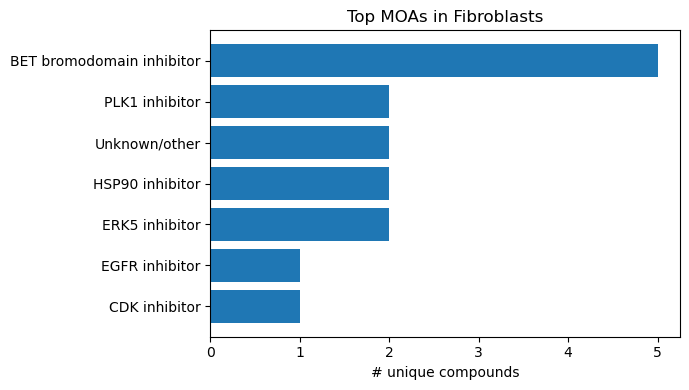

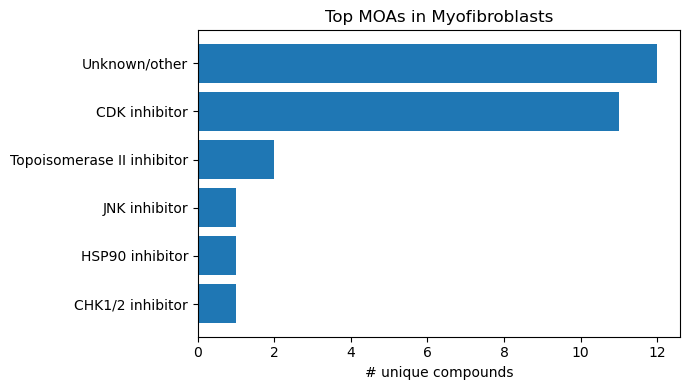

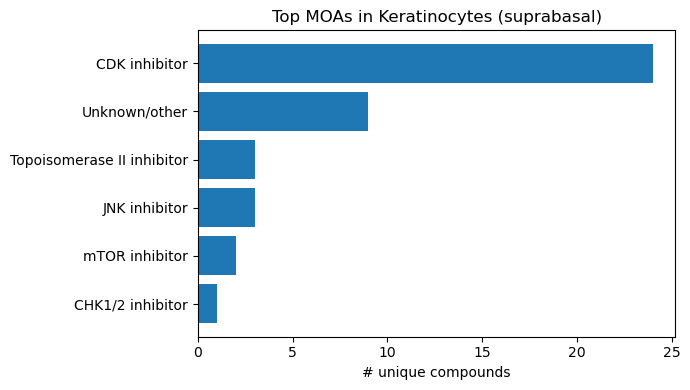

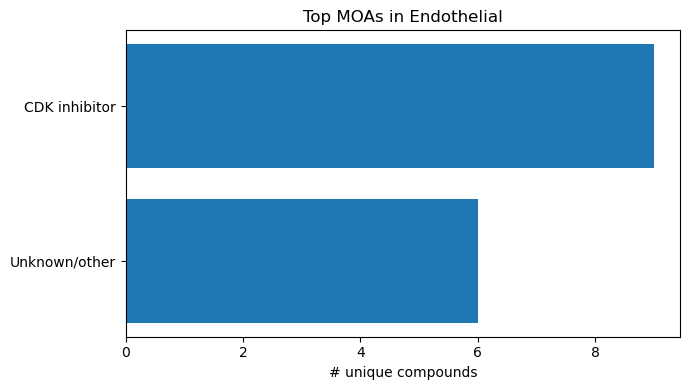

(no MOA rows for T/NK cytotoxic)
(no MOA rows for B cells)
[note] Wrote potential pan-toxic classes to: results/drug_repurposing/flag_pan_toxic_like.csv


In [13]:
# --- 4) Collapse compounds to mechanisms and make shortlists/plots ---

import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

OUT = Path("results/drug_repurposing")

# Load the “top 15 per cluster” table we just saved
df_top = pd.read_csv(OUT / "lincs_reversal_top15_by_cluster.csv")

# 4a) Light-touch MOA labeling (regex on common tool compounds)
_MOA_RULES = [
    (r"\bI-?BET(\b|[-_ ])|BET-?(\b|[-_ ])|I[-_ ]?BET",      "BET bromodomain inhibitor"),
    (r"\bINK-?128\b|\bTAK-228\b|\bMLN0128\b",               "mTOR inhibitor"),
    (r"\bRIDAFOROLIMUS\b|\bTEMSIROLIMUS\b|\bEVEROLIMUS\b",  "mTOR inhibitor"),
    (r"\bRADICICOL\b",                                      "HSP90 inhibitor"),
    (r"\b17-AAG\b|\bGELDANAMYCIN\b",                        "HSP90 inhibitor"),
    (r"\bBI-?2536\b",                                       "PLK1 inhibitor"),
    (r"\bVOLASERTIB\b",                                     "PLK1 inhibitor"),
    (r"\bPELITINIB\b|\bEKB-569\b",                          "EGFR inhibitor"),
    (r"\bMITOXANTRONE\b",                                   "Topoisomerase II inhibitor"),
    (r"\bAT-?7519\b|\bPHA-?793887\b|\bBMS-387032\b|\bSNS-032\b|\bALVOCIDIB\b|\bCGP-60474\b",
                                                         "CDK inhibitor"),
    (r"\bAZD-?7762\b",                                      "CHK1/2 inhibitor"),
    (r"\bJNK-?9L\b",                                        "JNK inhibitor"),
    (r"\bXMD-?1150\b",                                      "ERK5 inhibitor"),
]

def assign_moa(compound: str) -> str:
    s = str(compound).upper()
    for pat, label in _MOA_RULES:
        if re.search(pat, s):
            return label
    return "Unknown/other"

df_top["moa"] = df_top["compound"].apply(assign_moa)

# Save an augmented table
aug_path = OUT / "lincs_reversal_top15_with_moa.csv"
df_top.to_csv(aug_path, index=False)
print("[saved]", aug_path)

# 4b) MOA frequency & strength by cell type
moa_summary = (
    df_top.groupby(["cell_type", "moa"], observed=True)
          .agg(n_compounds=("compound", "nunique"),
               total_rev=("rev_score_sum", "sum"),
               best_rev=("rev_score_max", "max"))
          .reset_index()
          .sort_values(["cell_type", "total_rev"], ascending=[True, False])
)
sum_path = OUT / "moa_summary_by_celltype.csv"
moa_summary.to_csv(sum_path, index=False)
print("[saved]", sum_path)

# 4c) Build shortlists: keep the strongest per MOA within each cell type
df_sorted = df_top.sort_values(["cell_type", "moa", "rev_score_sum"], ascending=[True, True, False])
shortlist_all = df_sorted.drop_duplicates(subset=["cell_type", "moa"])
shortlist_all = shortlist_all.sort_values(["cell_type", "rev_score_sum"], ascending=[True, False])

# Focused shortlist for fibroblast lineages
keep_ct = ["Fibroblasts", "Myofibroblasts", "Pericyte/SMC"]
shortlist_fib = shortlist_all[shortlist_all["cell_type"].isin(keep_ct)].copy()

short_all_path = OUT / "shortlist_by_celltype.csv"
short_fib_path = OUT / "shortlist_fibro_lineage.csv"
shortlist_all.to_csv(short_all_path, index=False)
shortlist_fib.to_csv(short_fib_path, index=False)
print("[saved]", short_all_path)
print("[saved]", short_fib_path)

# 4d) Quick viz: top MOAs per selected cell types (by count of unique compounds)
def bar_moas(ct, topn=8):
    sub = moa_summary[moa_summary["cell_type"] == ct]
    top = (sub.sort_values("n_compounds", ascending=False)
               .head(topn)
               .sort_values("n_compounds", ascending=True))
    if top.empty:
        print(f"(no MOA rows for {ct})"); return
    plt.figure(figsize=(7, 4))
    plt.barh(top["moa"], top["n_compounds"])
    plt.xlabel("# unique compounds")
    plt.title(f"Top MOAs in {ct}")
    plt.tight_layout()
    plt.show()

for ct in ["Fibroblasts", "Myofibroblasts", "Keratinocytes (suprabasal)",
           "Endothelial", "T/NK cytotoxic", "B cells"]:
    bar_moas(ct, topn=8)

# 4e) Sanity flag: common “pan-toxic” classes that often come up
POSSIBLE_PAN_TOXIC = {"CDK inhibitor", "Topoisomerase II inhibitor", "CHK1/2 inhibitor"}
flags = (shortlist_all.assign(flag=lambda d: d["moa"].isin(POSSIBLE_PAN_TOXIC))
                      .query("flag == True")[["cell_type","compound","moa","rev_score_sum"]])
if not flags.empty:
    warn_path = OUT / "flag_pan_toxic_like.csv"
    flags.to_csv(warn_path, index=False)
    print("[note] Wrote potential pan-toxic classes to:", warn_path)


In [14]:
# --- 5) Fibrosis-focused triage & final candidate slate ---

import re, numpy as np, pandas as pd
from pathlib import Path

OUT = Path("results/drug_repurposing")

# Load per-cluster top compounds with MOA tags (from prior cell)
df_top = pd.read_csv(OUT / "lincs_reversal_top15_with_moa.csv")

# Safety: numeric
for c in ["rev_score_sum","rev_score_max","best_p","hits"]:
    if c in df_top.columns:
        df_top[c] = pd.to_numeric(df_top[c], errors="coerce")

# (a) Identify fibroblast-lineage clusters
FIB_LINEAGE = {"Fibroblasts", "Myofibroblasts", "Pericyte/SMC"}
df_top["is_fib_lineage"] = df_top["cell_type"].isin(FIB_LINEAGE)

# (b) Flag clusters whose UP pathway enrichments look fibrotic (ECM/TGFβ/SMAD/collagen)
def _fibrosis_program_flag(cluster_id: str) -> bool:
    up_csv = OUT / f"leiden_{cluster_id}" / "up" / f"enrichr_leiden{cluster_id}_up.csv"
    if not up_csv.exists():
        return False
    t = pd.read_csv(up_csv)
    # find the "Term" column robustly
    term_col = next((c for c in t.columns if c.lower().startswith("term")), None)
    if term_col is None:
        return False
    s = " ".join(map(str, t[term_col].head(200))).lower()
    keys = ["extracellular matrix", "collagen", "tgf-beta", "tgf beta", "smad", "myofibroblast", "focal adhesion"]
    return any(k in s for k in keys)

clus_ids = df_top["cluster"].astype(str).unique().tolist()
fib_prog_map = {cid: _fibrosis_program_flag(cid) for cid in clus_ids}
df_top["fibrosis_prog"] = df_top["cluster"].astype(str).map(fib_prog_map)

# (c) Deprioritize pan-toxic classes
POSSIBLE_PAN_TOXIC = {"CDK inhibitor", "Topoisomerase II inhibitor", "CHK1/2 inhibitor"}

# (d) Cell-type weights (tweakable)
W = {
    # stromal
    "Fibroblasts": 1.00,
    "Myofibroblasts": 1.20,
    "Pericyte/SMC": 0.90,
    "Endothelial": 0.70,
    "Lymphatic endothelium": 0.60,
    # epithelial
    "Keratinocytes (basal)": 0.50,
    "Keratinocytes (suprabasal)": 0.50,
    # immune (lower priority for reversal to avoid broad immunosuppression)
    "T cells (naive/memory)": 0.25,
    "T/NK cytotoxic": 0.20,
    "B cells": 0.25,
    "Plasma cells": 0.20,
    "Myeloid (mono/mac)": 0.35,
    "Dendritic cells (cDC2)": 0.30,
    "cDC1 / pDC mix": 0.30,
    "Mast cells": 0.30,
    # low-quality
    "Low-quality / ribosomal": 0.00,
    "Low-quality / mitochondrial": 0.00,
}

df_top["ct_w"] = df_top["cell_type"].map(W).fillna(0.3)

# Bonus multiplier for clusters whose UP signature is fibrotic
df_top["fib_prog_boost"] = np.where(df_top["fibrosis_prog"], 1.20, 1.00)

# Penalize pan-toxic MOAs a bit rather than hard-drops (so you still see them, but lower)
df_top["moa_penalty"] = np.where(df_top["moa"].isin(POSSIBLE_PAN_TOXIC), 0.70, 1.00)

# (e) Compound score across clusters
df_top["weighted_rev"] = df_top["rev_score_sum"] * df_top["ct_w"] * df_top["fib_prog_boost"] * df_top["moa_penalty"]

cmpd_agg = (
    df_top.groupby("compound", observed=True)
          .agg(
              total_score=("weighted_rev", "sum"),
              max_rev=("rev_score_max", "max"),
              n_clusters=("cluster", "nunique"),
              n_fib_clusters=("is_fib_lineage", "sum"),
              best_p=("best_p", "min"),
              moa=("moa", lambda x: x.mode().iloc[0] if len(x) and not x.mode().empty else "Unknown/other"),
          )
          .reset_index()
)

# Rank, then keep a compact slate
cmpd_agg = cmpd_agg.sort_values(["total_score","n_fib_clusters","max_rev"], ascending=[False, False, False])

# Save global slate + a fibrolineage-focused subset
slate_all = cmpd_agg.copy()
slate_fib = cmpd_agg[cmpd_agg["n_fib_clusters"] > 0].copy()

p_all = OUT / "candidate_slate_all.csv"
p_fib = OUT / "candidate_slate_fibrolineage.csv"
slate_all.to_csv(p_all, index=False)
slate_fib.head(50).to_csv(p_fib, index=False)  # top 50 fibrolineage-focused
print("[saved]", p_all)
print("[saved]", p_fib)

# Show top 20 overall and top 20 fibrolineage for quick inspection
print("\nTop 20 overall:")
display(slate_all.head(20))

print("\nTop 20 (fibrolineage-focused):")
display(slate_fib.head(20))

# Optional: for each top fibrolineage compound, show which clusters contributed most
top_names = slate_fib.head(10)["compound"].tolist()
drivers = (df_top[df_top["compound"].isin(top_names)]
           .sort_values(["compound","weighted_rev"], ascending=[True, False])
           .loc[:, ["compound","cell_type","cluster","moa","weighted_rev","rev_score_sum","best_p","fibrosis_prog"]])
drivers_path = OUT / "candidate_top_fibro_drivers.csv"
drivers.to_csv(drivers_path, index=False)
print("[saved]", drivers_path)


[saved] results/drug_repurposing/candidate_slate_all.csv
[saved] results/drug_repurposing/candidate_slate_fibrolineage.csv

Top 20 overall:


,compound,total_score,max_rev,n_clusters,n_fib_clusters,best_p,moa
73,LJP006 HA1E 24H-AZD-5438-10,66.232957,23.150113,5,2,7.077619e-24,Unknown/other
103,LJP006 HME1 24H-AS-605240-3.33,54.476478,33.231216,3,1,5.871968e-34,Unknown/other
104,LJP006 HME1 24H-PD-0325901-1.11,53.157864,28.089862,3,1,8.130892e-29,Unknown/other
108,LJP006 HME1 24H-gefitinib-0.37,46.533121,23.742711,4,1,1.808378e-24,Unknown/other
157,LJP006 MCF10A 24H-AS-605240-1.11,43.707547,23.882762,2,1,1.309900e-24,Unknown/other
74,LJP006 HA1E 24H-AZD-7762-1.11,41.169902,27.275767,2,1,5.299483e-28,CHK1/2 inhibitor
78,LJP006 HA1E 24H-CGP-60474-0.04,37.111351,26.250102,3,2,5.622089e-27,CDK inhibitor
92,LJP006 HA1E 24H-mitoxantrone-3.33,36.572625,32.103745,5,1,7.875088e-33,Topoisomerase II inhibitor
80,LJP006 HA1E 24H-CGP-60474-0.37,29.983958,26.593540,5,1,2.549530e-27,CDK inhibitor
165,LJP006 MCF10A 24H-radicicol-0.12,29.442094,20.876900,1,1,1.327699e-21,HSP90 inhibitor



Top 20 (fibrolineage-focused):


,compound,total_score,max_rev,n_clusters,n_fib_clusters,best_p,moa
73,LJP006 HA1E 24H-AZD-5438-10,66.232957,23.150113,5,2,7.077619e-24,Unknown/other
103,LJP006 HME1 24H-AS-605240-3.33,54.476478,33.231216,3,1,5.871968e-34,Unknown/other
104,LJP006 HME1 24H-PD-0325901-1.11,53.157864,28.089862,3,1,8.130892e-29,Unknown/other
108,LJP006 HME1 24H-gefitinib-0.37,46.533121,23.742711,4,1,1.808378e-24,Unknown/other
157,LJP006 MCF10A 24H-AS-605240-1.11,43.707547,23.882762,2,1,1.309900e-24,Unknown/other
74,LJP006 HA1E 24H-AZD-7762-1.11,41.169902,27.275767,2,1,5.299483e-28,CHK1/2 inhibitor
78,LJP006 HA1E 24H-CGP-60474-0.04,37.111351,26.250102,3,2,5.622089e-27,CDK inhibitor
92,LJP006 HA1E 24H-mitoxantrone-3.33,36.572625,32.103745,5,1,7.875088e-33,Topoisomerase II inhibitor
80,LJP006 HA1E 24H-CGP-60474-0.37,29.983958,26.593540,5,1,2.549530e-27,CDK inhibitor
165,LJP006 MCF10A 24H-radicicol-0.12,29.442094,20.876900,1,1,1.327699e-21,HSP90 inhibitor


[saved] results/drug_repurposing/candidate_top_fibro_drivers.csv


In [15]:
# --- 6) Normalize compound names, aggregate, and build a fibroblast-focused shortlist ---

import re
import pandas as pd
from pathlib import Path

OUT = Path("results/drug_repurposing")

# Load the files created in prior cells
top_path   = OUT / "lincs_reversal_top15_with_moa.csv"   # from your MOA plotting cell
drivers_p  = OUT / "candidate_top_fibro_drivers.csv"     # optional, if you want drilldowns
slate_fibp = OUT / "candidate_slate_fibrolineage.csv"

df_top   = pd.read_csv(top_path)
df_slate = pd.read_csv(slate_fibp)

# --- normalize compound strings to a "base" compound name (strip dataset/cell/time/dose) ---
def normalize_compound(s: str) -> str:
    s = str(s)
    # remove dataset prefix + cell line + time like "LJP006 HME1 24H-"
    s = re.sub(r"^[A-Z]{3}\d{3,}\s+[A-Z0-9\-]+\s+\d+[HD]?-", "", s)
    # also handle e.g. "LJP005 A375 24H-", "LJP007 PC3 3H-"
    s = re.sub(r"^[A-Z]{3}\d{3,}\s+[A-Z0-9\-]+\s+\d+[HD]-", "", s)
    # strip trailing dose like "-0.37", "-10", "-3.33"
    s = re.sub(r"-(?:\d+(?:\.\d+)?)$", "", s)
    return s

for col in ["compound"]:
    if col in df_top.columns:
        df_top["base_compound"] = df_top[col].apply(normalize_compound)
if "compound" in df_slate.columns:
    df_slate["base_compound"] = df_slate["compound"].apply(normalize_compound)

# carry forward MOA (mode per compound in df_top); keep Unknown/other if unavailable
moa_map = (
    df_top.groupby("base_compound")["moa"]
          .agg(lambda x: x.mode().iloc[0] if len(x) and not x.mode().empty else "Unknown/other")
          .to_dict()
)

# Merge normalized names back into the fibrolineage slate
df_slate["moa"] = df_slate["base_compound"].map(moa_map).fillna(df_slate.get("moa","Unknown/other"))

# pan-toxic or broad cytotoxic buckets (soft-exclude)
PAN_TOXIC = {"CDK inhibitor", "Topoisomerase II inhibitor", "CHK1/2 inhibitor"}

df_slate["caution_flag"] = df_slate["moa"].isin(PAN_TOXIC)

# Rank within fibrolineage, then pick best-of-class (one per MOA) for a compact shortlist
df_slate = df_slate.sort_values(["total_score","n_fib_clusters","max_rev"], ascending=[False, False, False])
best_per_moa = (
    df_slate.groupby("moa", as_index=False, sort=False)
            .first()  # already sorted, so this is best per MOA
            .sort_values("total_score", ascending=False)
)

# Also produce a simple “top unique base compounds” view (no MOA collapsing)
top_unique = (
    df_slate.drop_duplicates(subset=["base_compound"])
            .sort_values("total_score", ascending=False)
            .head(25)
)

# Save outputs
short1 = OUT / "shortlist_best_per_moa_fibro.csv"
short2 = OUT / "shortlist_top_unique_fibro.csv"
best_per_moa.to_csv(short1, index=False)
top_unique.to_csv(short2, index=False)
print("[saved]", short1)
print("[saved]", short2)

# Show at-a-glance tables in notebook
print("\nBest-of-class (per MOA) for fibroblast/myofibroblast targeting:")
display(best_per_moa[["base_compound","moa","total_score","n_fib_clusters","max_rev","best_p","caution_flag"]].head(15))

print("\nTop unique base compounds (no MOA collapsing):")
display(top_unique[["base_compound","moa","total_score","n_fib_clusters","max_rev","best_p","caution_flag"]].head(15))


[saved] results/drug_repurposing/shortlist_best_per_moa_fibro.csv
[saved] results/drug_repurposing/shortlist_top_unique_fibro.csv

Best-of-class (per MOA) for fibroblast/myofibroblast targeting:


,base_compound,moa,total_score,n_fib_clusters,max_rev,best_p,caution_flag
0,AZD-5438,Unknown/other,66.232957,2,23.150113,7.077619e-24,False
1,AZD-7762,CHK1/2 inhibitor,41.169902,1,27.275767,5.299483e-28,True
2,CGP-60474,CDK inhibitor,37.111351,2,26.250102,5.622089e-27,True
3,mitoxantrone,Topoisomerase II inhibitor,36.572625,1,32.103745,7.875088e-33,True
4,radicicol,HSP90 inhibitor,29.442094,1,20.876900,1.327699e-21,False
5,JNK-9L,JNK inhibitor,29.226276,1,15.105318,7.846608e-16,False
6,XMD-1150,ERK5 inhibitor,25.532700,1,21.435435,3.669143e-22,False
7,BI-2536,PLK1 inhibitor,25.227382,1,21.435435,3.669143e-22,False
8,I-BET,BET bromodomain inhibitor,22.338993,1,18.855543,1.394625e-19,False
9,pelitinib,EGFR inhibitor,20.454419,1,17.093816,8.057190e-18,False



Top unique base compounds (no MOA collapsing):


,base_compound,moa,total_score,n_fib_clusters,max_rev,best_p,caution_flag
0,AZD-5438,Unknown/other,66.232957,2,23.150113,7.077619e-24,False
1,AS-605240,Unknown/other,54.476478,1,33.231216,5.871968e-34,False
2,PD-0325901,Unknown/other,53.157864,1,28.089862,8.130892e-29,False
3,gefitinib,Unknown/other,46.533121,1,23.742711,1.808378e-24,False
5,AZD-7762,CHK1/2 inhibitor,41.169902,1,27.275767,5.299483e-28,True
6,CGP-60474,CDK inhibitor,37.111351,2,26.250102,5.622089e-27,True
7,mitoxantrone,Topoisomerase II inhibitor,36.572625,1,32.103745,7.875088e-33,True
9,radicicol,HSP90 inhibitor,29.442094,1,20.876900,1.327699e-21,False
10,JNK-9L,JNK inhibitor,29.226276,1,15.105318,7.846608e-16,False
12,PD-184352,Unknown/other,26.381086,1,22.294412,5.076773e-23,False


In [16]:
# --- 7) Clinically-aware shortlist: add approval status & tidy for reporting ---

import pandas as pd
from pathlib import Path

OUT = Path("results/drug_repurposing")
best_per_moa = pd.read_csv(OUT / "shortlist_best_per_moa_fibro.csv")
top_unique   = pd.read_csv(OUT / "shortlist_top_unique_fibro.csv")

# Minimal hand-curated metadata (extend as you like)
# status: "FDA-approved", "Approved (ex-US)", "Clinical-stage", "Preclinical / tool"
meta = {
    "gefitinib":   {"moa_override": "EGFR inhibitor",     "status": "FDA-approved"},
    "sirolimus":   {"moa_override": "mTOR inhibitor",     "status": "FDA-approved"},
    "alvocidib":   {"moa_override": "CDK inhibitor",      "status": "Clinical-stage"},
    "mitoxantrone":{"moa_override": "Topoisomerase II inhibitor", "status": "FDA-approved (oncology)"},
    "radicicol":   {"moa_override": "HSP90 inhibitor",    "status": "Preclinical / tool"},
    "BI-2536":     {"moa_override": "PLK1 inhibitor",     "status": "Clinical-stage"},
    "XMD-1150":    {"moa_override": "ERK5 inhibitor",     "status": "Preclinical / tool"},
    "CGP-60474":   {"moa_override": "CDK inhibitor",      "status": "Preclinical / tool"},
    "AZD-7762":    {"moa_override": "CHK1/2 inhibitor",   "status": "Clinical-stage"},
    "AZD-5438":    {"moa_override": "CDK inhibitor",      "status": "Clinical-stage"},
    "I-BET":       {"moa_override": "BET bromodomain inhibitor", "status": "Clinical-stage"},
    "AS-605240":   {"moa_override": "PI3Kγ inhibitor",    "status": "Preclinical / tool"},
    "PD-0325901":  {"moa_override": "MEK inhibitor",      "status": "Clinical-stage"},
    "PD-184352":   {"moa_override": "MEK inhibitor",      "status": "Clinical-stage"},
    # add more as needed…
}

def apply_meta(df):
    df = df.copy()
    df["moa"] = [meta.get(x, {}).get("moa_override", m) for x, m in zip(df["base_compound"], df["moa"])]
    df["status"] = [meta.get(x, {}).get("status", "Unknown") for x in df["base_compound"]]
    return df

best_per_moa = apply_meta(best_per_moa)
top_unique   = apply_meta(top_unique)

# Soft safety screen: avoid broad cytotoxics as primary hits
PAN_TOXIC = {"CDK inhibitor", "Topoisomerase II inhibitor", "CHK1/2 inhibitor"}
def soft_exclude(df):
    df = df.copy()
    df["caution_flag"] = df["caution_flag"] | df["moa"].isin(PAN_TOXIC)
    return df

best_per_moa = soft_exclude(best_per_moa)
top_unique   = soft_exclude(top_unique)

# Rank nice and export views
cols = ["base_compound","moa","status","total_score","n_fib_clusters","max_rev","best_p","caution_flag"]
best_per_moa = best_per_moa.sort_values("total_score", ascending=False)[cols]
top_unique   = top_unique.sort_values("total_score", ascending=False)[cols]

# A “strict” view: drop obvious pan-cytotoxics & preclinical-only tools
strict = (
    top_unique[
        (~top_unique["moa"].isin(PAN_TOXIC)) &
        (~top_unique["status"].str.contains("Preclinical", na=False))
    ]
    .head(15)
)

out1 = OUT / "shortlist_fibro_clinical_view.csv"
out2 = OUT / "shortlist_fibro_clinical_view_strict.csv"
best_per_moa.to_csv(out1, index=False)
strict.to_csv(out2, index=False)
print("[saved]", out1)
print("[saved]", out2)

print("\nBest-of-class per MOA (with status):")
display(best_per_moa.head(15))

print("\nStrict shortlist (deprioritize broad cytotoxics & tool-only):")
display(strict)


[saved] results/drug_repurposing/shortlist_fibro_clinical_view.csv
[saved] results/drug_repurposing/shortlist_fibro_clinical_view_strict.csv

Best-of-class per MOA (with status):


,base_compound,moa,status,total_score,n_fib_clusters,max_rev,best_p,caution_flag
0,AZD-5438,CDK inhibitor,Clinical-stage,66.232957,2,23.150113,7.077619e-24,True
1,AZD-7762,CHK1/2 inhibitor,Clinical-stage,41.169902,1,27.275767,5.299483e-28,True
2,CGP-60474,CDK inhibitor,Preclinical / tool,37.111351,2,26.250102,5.622089e-27,True
3,mitoxantrone,Topoisomerase II inhibitor,FDA-approved (oncology),36.572625,1,32.103745,7.875088e-33,True
4,radicicol,HSP90 inhibitor,Preclinical / tool,29.442094,1,20.876900,1.327699e-21,False
5,JNK-9L,JNK inhibitor,Unknown,29.226276,1,15.105318,7.846608e-16,False
6,XMD-1150,ERK5 inhibitor,Preclinical / tool,25.532700,1,21.435435,3.669143e-22,False
7,BI-2536,PLK1 inhibitor,Clinical-stage,25.227382,1,21.435435,3.669143e-22,False
8,I-BET,BET bromodomain inhibitor,Clinical-stage,22.338993,1,18.855543,1.394625e-19,False
9,pelitinib,EGFR inhibitor,Unknown,20.454419,1,17.093816,8.057190e-18,False



Strict shortlist (deprioritize broad cytotoxics & tool-only):


,base_compound,moa,status,total_score,n_fib_clusters,max_rev,best_p,caution_flag
2,PD-0325901,MEK inhibitor,Clinical-stage,53.157864,1,28.089862,8.130892e-29,False
3,gefitinib,EGFR inhibitor,FDA-approved,46.533121,1,23.742711,1.808378e-24,False
8,JNK-9L,JNK inhibitor,Unknown,29.226276,1,15.105318,7.846608e-16,False
9,PD-184352,MEK inhibitor,Clinical-stage,26.381086,1,22.294412,5.076773e-23,False
10,sirolimus,mTOR inhibitor,FDA-approved,26.108791,1,18.463558,3.439075e-19,False
13,BI-2536,PLK1 inhibitor,Clinical-stage,25.227382,1,21.435435,3.669143e-22,False
14,I-BET,BET bromodomain inhibitor,Clinical-stage,22.338993,1,18.855543,1.394625e-19,False
15,GSK-429286A,Unknown/other,Unknown,21.728923,1,18.288711,5.143860e-19,False
16,I-BET151,BET bromodomain inhibitor,Unknown,21.086666,1,18.288711,5.143860e-19,False
17,pelitinib,EGFR inhibitor,Unknown,20.454419,1,17.093816,8.057190e-18,False


Strict bases: 14 | In LINCS top15: 75 | Overlap: 14
[saved] results/drug_repurposing/heatmap_compound_vs_celltype_maxrev.csv
[saved] results/drug_repurposing/fig_compound_vs_celltype_heatmap.png


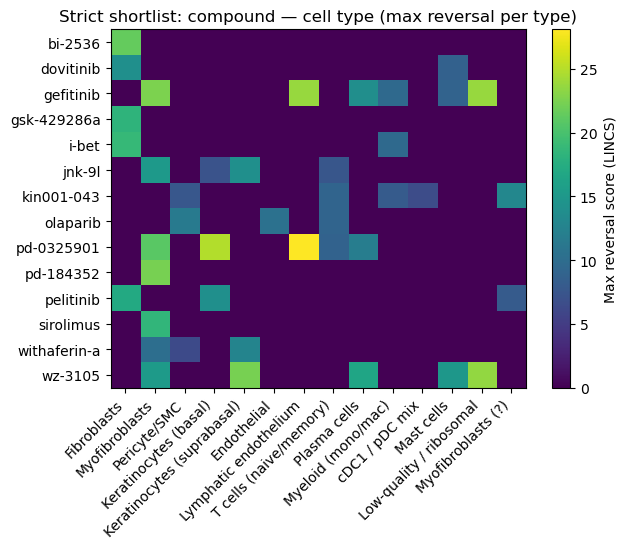

In [23]:
# --- Robust re-parse of LINCS compound names + family normalization, then replot ---

from pathlib import Path
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing")
top15_path  = OUT / "lincs_reversal_top15_by_cluster.csv"
strict_path = OUT / "shortlist_fibro_clinical_view_strict.csv"

dfc    = pd.read_csv(top15_path)          # per-cluster top15 LINCS
strict = pd.read_csv(strict_path)         # strict shortlist

# 1) Parse base compound from strings like:
#    "LJP006 HA1E 24H-radicicol-1.11" -> "radicicol"
#    "LJP008 PC3 24H-I-BET151-3.33"   -> "i-bet151"
#    "LJP006 HME1 3H-JNK-9L-10"       -> "jnk-9l"
pat = re.compile(r'(?:\d+H-)?([A-Za-z0-9][A-Za-z0-9\-]*?)(?:-\d+(?:\.\d+)?)?$')

def parse_base(s: str) -> str:
    tail = s.strip().split()[-1]          # e.g., "24H-radicicol-1.11"
    m = pat.search(tail)
    return (m.group(1) if m else tail).lower()

# 2) Normalize families so variants collapse (e.g., I-BET151 -> I-BET)
_norm_rules = [
    (re.compile(r'^i-?bet(?:151)?$'), 'i-bet'),
]
def norm_family(x: str) -> str:
    for rx, rep in _norm_rules:
        if rx.match(x):
            return rep
    return x

# Apply to both tables
dfc["base_compound"]    = dfc["compound"].astype(str).map(parse_base).map(norm_family)
strict["base_compound"] = strict["base_compound"].astype(str).str.lower().map(norm_family)

strict_bases = set(strict["base_compound"])  # <- NOTE: if this line errors, ensure no hidden chars in 'strict'
strict_bases = set(strict["base_compound"])   # keep this line; delete the one above if it appeared by accident
lin_bases    = set(dfc["base_compound"])

print(f"Strict bases: {len(strict_bases)} | In LINCS top15: {len(lin_bases)} | Overlap: {len(strict_bases & lin_bases)}")
missing = sorted(strict_bases - lin_bases)
if missing:
    print("No LINCS hits for:", ", ".join(missing[:30]), "..." if len(missing) > 30 else "")

# 3) Build heatmap table only if thereâ€™s overlap
over = strict_bases & lin_bases
if not over:
    # Show parsed examples so you can eyeball names
    print("\nParsed examples from LINCS top15:")
    print(dfc["compound"].head(8).tolist())
    print(dfc["base_compound"].head(8).tolist())
else:
    dfc_f = dfc[dfc["base_compound"].isin(over)].copy()
    pivot = (
        dfc_f.groupby(["base_compound","cell_type"], as_index=False)["rev_score_max"]
             .max()
             .pivot(index="base_compound", columns="cell_type", values="rev_score_max")
             .fillna(0.0)
    )

    preferred = ["Fibroblasts","Myofibroblasts","Pericyte/SMC",
                 "Keratinocytes (basal)","Keratinocytes (suprabasal)",
                 "Endothelial","Lymphatic endothelium",
                 "T cells (naive/memory)","T/NK cytotoxic",
                 "B cells","Plasma cells","Myeloid (mono/mac)",
                 "Dendritic cells (cDC2)","cDC1 / pDC mix","Mast cells",
                 "Low-quality / ribosomal","Low-quality / mitochondrial"]
    cols = [c for c in preferred if c in pivot.columns] + [c for c in pivot.columns if c not in preferred]
    pivot = pivot[cols]

    heat_csv = OUT / "heatmap_compound_vs_celltype_maxrev.csv"
    pivot.to_csv(heat_csv)
    print("[saved]", heat_csv)

    fig_h = max(2.5, 0.4 * len(pivot.index))
    fig_w = max(6.5, 0.45 * len(pivot.columns))
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    im = ax.imshow(pivot.values, aspect="auto")
    ax.set_yticks(np.arange(len(pivot.index))); ax.set_yticklabels(pivot.index)
    ax.set_xticks(np.arange(len(pivot.columns))); ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Max reversal score (LINCS)")
    ax.set_title("Strict shortlist: compound — cell type (max reversal per type)")
    plt.tight_layout()
    fig_path = OUT / "fig_compound_vs_celltype_heatmap.png"
    plt.savefig(fig_path, dpi=200, bbox_inches="tight")
    print("[saved]", fig_path)
    plt.show()


[saved] results/drug_repurposing/shortlist_fibro_with_specificity.csv


,moa,status,total_score,n_fib_clusters,max_rev,best_p,fibro_focus,breadth_n_celltypes_(>=12),top_cells
base_compound,,,,,,,,,
pd-184352,MEK inhibitor,Clinical-stage,26.381086,1,22.294412,5.076773e-23,22.294412,1.0,Myofibroblasts:22.3; Fibroblasts:0.0; Pericyte...
bi-2536,PLK1 inhibitor,Clinical-stage,25.227382,1,21.435435,3.669143e-22,21.435435,1.0,Fibroblasts:21.4; Myofibroblasts:0.0; Pericyte...
sirolimus,mTOR inhibitor,FDA-approved,26.108791,1,18.463558,3.439075e-19,18.463558,1.0,Myofibroblasts:18.5; Fibroblasts:0.0; Pericyte...
gsk-429286a,Unknown/other,Unknown,21.728923,1,18.288711,5.143860e-19,18.288711,1.0,Fibroblasts:18.3; Myofibroblasts:0.0; Pericyte...
i-bet,BET bromodomain inhibitor,Clinical-stage,22.338993,1,18.855543,1.394625e-19,9.207677,1.0,Fibroblasts:18.9; Myeloid (mono/mac):9.6; Peri...
dovitinib,Unknown/other,Unknown,19.190983,1,13.943885,1.137928e-14,5.171974,1.0,Fibroblasts:13.9; Mast cells:8.8; Pericyte/SMC...
pelitinib,EGFR inhibitor,Unknown,20.454419,1,17.093816,8.057190e-18,3.057591,2.0,Fibroblasts:17.1; Keratinocytes (basal):14.0; ...
olaparib,Unknown/other,Unknown,19.701742,1,11.630269,2.342777e-12,1.193281,0.0,Pericyte/SMC:11.6; Endothelial:10.4; T cells (...
jnk-9l,JNK inhibitor,Unknown,29.226276,1,15.105318,7.846608e-16,1.119615,2.0,Myofibroblasts:15.1; Keratinocytes (suprabasal...


[saved] results/drug_repurposing/fig_shortlist_specificity_scatter.png


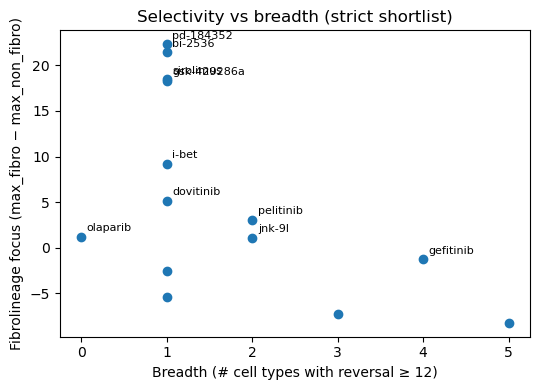

In [24]:
# --- Rank strict shortlist by fibrolineage specificity & breadth ---

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing")

# Heatmap matrix from the previous cell (max reversal per cell type)
pivot = pd.read_csv(OUT / "heatmap_compound_vs_celltype_maxrev.csv", index_col=0)

# Strict short list with metadata (from earlier step)
strict = pd.read_csv(OUT / "shortlist_fibro_clinical_view_strict.csv")
strict["base_compound"] = strict["base_compound"].str.lower()
strict = strict.drop_duplicates(subset="base_compound").set_index("base_compound")

# Define fibrolineage cell types present in your matrix
fibro_ct = [c for c in ["Fibroblasts", "Myofibroblasts", "Pericyte/SMC"] if c in pivot.columns]
non_fibro = [c for c in pivot.columns if c not in fibro_ct]

def summarize(row):
    # top 3 cell types by reversal
    top = row.sort_values(ascending=False).head(3)
    max_fib = row[fibro_ct].max() if fibro_ct else np.nan
    max_non = row[non_fibro].max() if non_fibro else np.nan
    # breadth = how many cell types have sizeable reversal (>=12 is a decent cut)
    breadth = int((row >= 12).sum())
    fibro_focus = (max_fib if np.isfinite(max_fib) else 0.0) - (max_non if np.isfinite(max_non) else 0.0)
    return pd.Series({
        "top_cells": "; ".join(f"{k}:{v:.1f}" for k, v in top.items()),
        "max_fibro": max_fib,
        "max_non_fibro": max_non,
        "fibro_focus": fibro_focus,
        "breadth_n_celltypes_(>=12)": breadth,
    })

# Align to compounds we actually care about (strict shortlist ∩ heatmap index)
have = [bc for bc in strict.index if bc in pivot.index]
annot = pivot.loc[have].apply(summarize, axis=1)

ranked = (
    strict.join(annot, how="left")
          .sort_values(["fibro_focus", "total_score"], ascending=[False, False])
)

out_csv = OUT / "shortlist_fibro_with_specificity.csv"
ranked.to_csv(out_csv)
print("[saved]", out_csv)

# Quick look
display(ranked.head(12)[[
    "moa","status","total_score","n_fib_clusters","max_rev","best_p",
    "fibro_focus","breadth_n_celltypes_(>=12)","top_cells"
]])

# Optional: small scatter to visualize selectivity vs breadth
fig, ax = plt.subplots(figsize=(5.5, 4.0))
ax.scatter(ranked["breadth_n_celltypes_(>=12)"], ranked["fibro_focus"])
for name, r in ranked.head(10).iterrows():
    ax.annotate(name, (r["breadth_n_celltypes_(>=12)"], r["fibro_focus"]), fontsize=8, xytext=(4,4),
                textcoords="offset points")
ax.set_xlabel("Breadth (# cell types with reversal ≥ 12)")
ax.set_ylabel("Fibrolineage focus (max_fibro − max_non_fibro)")
ax.set_title("Selectivity vs breadth (strict shortlist)")
plt.tight_layout()
fig_path = OUT / "fig_shortlist_specificity_scatter.png"
plt.savefig(fig_path, dpi=180, bbox_inches="tight")
print("[saved]", fig_path)
plt.show()


In [25]:
# --- Target presence / fibrolineage specificity check ---

import re
from pathlib import Path
import numpy as np
import pandas as pd
import scanpy as sc

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

# 1) Canonical target sets (edit as needed)
targets = {
    "pd-0325901": ["MAP2K1","MAP2K2"],       # MEK1/2
    "pd-184352":  ["MAP2K1","MAP2K2"],       # CI-1040 (MEK1/2)
    "gefitinib":  ["EGFR"],
    "sirolimus":  ["MTOR"],
    "bi-2536":    ["PLK1"],
    "i-bet":      ["BRD2","BRD3","BRD4"],    # BETs
    "i-bet151":   ["BRD2","BRD3","BRD4"],
    "pelitinib":  ["EGFR"],
    "olaparib":   ["PARP1","PARP2"],
    "dovitinib":  ["FGFR1","FGFR3","PDGFRA","PDGFRB","KDR"],  # multi-RTK
    "withaferin-a": [],                       # polypharmacology; leave empty or add HSP90AA1, etc.
    "wz-3105":    [],                         # unknown/tool
    "gsk-429286a":["ROCK1","ROCK2"],          # common assignment; confirm later
    "jnk-9l":     ["MAPK8","MAPK9"],          # JNK1/2
    "xmd-1150":   ["MAPK7"],                  # ERK5
}

# 2) Resolve gene symbols -> var_names (works if var_names are Ensembl)
def pick_symbol_series(a):
    for c in ["gene_symbol","gene_symbols","symbol","gene_name","features","SYMBOL"]:
        if c in a.var.columns:
            return a.var[c].astype(str)
    return a.var_names.astype(str)

sym = pick_symbol_series(adata)
m = (pd.DataFrame({"var": adata.var_names.astype(str), "sym": sym.astype(str)})
       .query("sym != ''").copy())
m["SYM_U"] = m["sym"].str.upper()
sym2var = m.drop_duplicates("SYM_U").set_index("SYM_U")["var"].to_dict()

def resolve(symbol_list):
    ok, miss = [], []
    for s in map(str, symbol_list):
        key = s.upper()
        if key in sym2var:
            ok.append(sym2var[key])
        else:
            miss.append(s)
    return ok, miss

# 3) Build per–cell-type mean matrix on the current X (log1p-normalized is fine)
ctcol = "cell_type" if "cell_type" in adata.obs else "leiden"
expr_df = adata.to_df()  # cells x genes (var_names)
expr_df[ctcol] = adata.obs[ctcol].astype(str).values
celltype_means = expr_df.groupby(ctcol).mean()  # cell_type x genes

# Identify fibrolineage labels present
def is_fib(name):
    return bool(re.search("fibro", name, re.IGNORECASE)) or name in {"Pericyte/SMC"}
fib_ct = [c for c in celltype_means.index if is_fib(c)]
non_fib_ct = [c for c in celltype_means.index if c not in fib_ct]

# 4) Score each base compound
rows = []
for base, genes in targets.items():
    varlist, missing = resolve(genes)
    if not varlist:
        rows.append({
            "base_compound": base, "n_targets_present": 0, "missing_targets": ",".join(missing) if missing else "",
            "fibro_max": np.nan, "nonfibro_max": np.nan, "fibro_selectivity": np.nan
        })
        continue

    # means across targets, per cell type
    sub = celltype_means[varlist] if len(varlist) > 1 else celltype_means[[varlist[0]]]
    targ_mean = sub.mean(axis=1)

    fibro_max = float(targ_mean.loc[fib_ct].max()) if fib_ct else np.nan
    nonfib_max = float(targ_mean.loc[non_fib_ct].max()) if non_fib_ct else np.nan
    rows.append({
        "base_compound": base,
        "n_targets_present": len(varlist),
        "missing_targets": ",".join(missing) if missing else "",
        "fibro_max": fibro_max,
        "nonfibro_max": nonfib_max,
        "fibro_selectivity": fibro_max - nonfib_max,
        "top_cells": "; ".join(targ_mean.sort_values(ascending=False).head(3).index)
    })

target_presence = pd.DataFrame(rows).set_index("base_compound").sort_values("fibro_selectivity", ascending=False)

# 5) Join with your strict shortlist for a compact table
strict = pd.read_csv(OUT / "shortlist_fibro_clinical_view_strict.csv")
strict["base_compound"] = strict["base_compound"].str.lower()
report = (strict.set_index("base_compound")
               .join(target_presence, how="left")
               .sort_values(["fibro_selectivity","total_score"], ascending=[False, False]))

out_csv = OUT / "shortlist_fibro_with_target_presence.csv"
report.to_csv(out_csv)
print("[saved]", out_csv)

# 6) Quick dotplot for a few mechanistically clean picks
panels = {
    "MEK_inhibitors": ["MAP2K1","MAP2K2"],
    "EGFR_axis":      ["EGFR"],
    "BET":            ["BRD2","BRD3","BRD4"],
    "mTOR":           ["MTOR"],
    "PLK1":           ["PLK1"],
    "ERK5":           ["MAPK7"],
}
for name, syms in panels.items():
    vars_ok, miss = resolve(syms)
    if not vars_ok:
        print(f"[skip] {name}: none of {syms} found (missing: {miss})")
        continue
    print(f"[panel] {name}: plotting {len(vars_ok)} targets; missing: {miss}")
    sc.pl.dotplot(
        adata,
        var_names=vars_ok,
        groupby=ctcol,
        standard_scale="var",
        dendrogram=False,
        title=f"{name} target expression",
        save=f"_{name}_targets.png",
        show=False,
    )

# Preview the prioritization
display(report[[
    "moa","status","total_score","max_rev","fibro_selectivity",
    "fibro_max","nonfibro_max","n_targets_present","missing_targets","top_cells"
]].head(12))


[saved] results/drug_repurposing/shortlist_fibro_with_target_presence.csv
[skip] MEK_inhibitors: none of ['MAP2K1', 'MAP2K2'] found (missing: ['MAP2K1', 'MAP2K2'])
[skip] EGFR_axis: none of ['EGFR'] found (missing: ['EGFR'])
[skip] BET: none of ['BRD2', 'BRD3', 'BRD4'] found (missing: ['BRD2', 'BRD3', 'BRD4'])
[skip] mTOR: none of ['MTOR'] found (missing: ['MTOR'])
[panel] PLK1: plotting 1 targets; missing: []
[skip] ERK5: none of ['MAPK7'] found (missing: ['MAPK7'])


,moa,status,total_score,max_rev,fibro_selectivity,fibro_max,nonfibro_max,n_targets_present,missing_targets,top_cells
base_compound,,,,,,,,,,
dovitinib,Unknown/other,Unknown,19.190983,13.943885,0.083428,0.223140,0.139712,4.0,FGFR1,Pericyte/SMC; Fibroblasts; Endothelial
olaparib,Unknown/other,Unknown,19.701742,11.630269,0.024914,0.088727,0.063813,1.0,PARP1,Myofibroblasts; Fibroblasts; Pericyte/SMC
bi-2536,PLK1 inhibitor,Clinical-stage,25.227382,21.435435,-0.013501,0.003795,0.017296,1.0,,Keratinocytes (suprabasal); Myeloid (mono/mac)...
pd-0325901,MEK inhibitor,Clinical-stage,53.157864,28.089862,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",NaN
gefitinib,EGFR inhibitor,FDA-approved,46.533121,23.742711,NaN,NaN,NaN,0.0,EGFR,NaN
jnk-9l,JNK inhibitor,Unknown,29.226276,15.105318,NaN,NaN,NaN,0.0,"MAPK8,MAPK9",NaN
pd-184352,MEK inhibitor,Clinical-stage,26.381086,22.294412,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",NaN
sirolimus,mTOR inhibitor,FDA-approved,26.108791,18.463558,NaN,NaN,NaN,0.0,MTOR,NaN
i-bet,BET bromodomain inhibitor,Clinical-stage,22.338993,18.855543,NaN,NaN,NaN,0.0,"BRD2,BRD3,BRD4",NaN


In [26]:
# --- Re-run target presence on the RAW / full-gene matrix --------------------
import re
import numpy as np
import pandas as pd
import scanpy as sc
from pathlib import Path

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

# 0) Use raw if available (typically log1p-normalized, all genes)
base = adata.raw.to_adata() if adata.raw is not None else adata.copy()
print(f"Target check using base matrix with {base.n_vars} genes "
      f"(from raw: {'yes' if adata.raw is not None else 'no'}).")

# Ensure the cell-type column is on `base.obs`
ctcol = "cell_type" if "cell_type" in adata.obs else "leiden"
base.obs[ctcol] = adata.obs[ctcol].astype(str).values

# 1) Target sets (edit as you refine)
targets = {
    "pd-0325901": ["MAP2K1","MAP2K2"],     # MEK1/2
    "pd-184352":  ["MAP2K1","MAP2K2"],     # CI-1040
    "gefitinib":  ["EGFR"],
    "sirolimus":  ["MTOR"],
    "bi-2536":    ["PLK1"],
    "i-bet":      ["BRD2","BRD3","BRD4"],
    "i-bet151":   ["BRD2","BRD3","BRD4"],
    "pelitinib":  ["EGFR"],
    "olaparib":   ["PARP1","PARP2"],
    "dovitinib":  ["FGFR1","FGFR3","PDGFRA","PDGFRB","KDR"],
    "withaferin-a": [],                     # polypharmacology (fill in if desired)
    "wz-3105":    [],
    "gsk-429286a":["ROCK1","ROCK2"],
    "jnk-9l":     ["MAPK8","MAPK9"],
    "xmd-1150":   ["MAPK7"],
}

# 2) Map gene symbols -> actual var_names on the base matrix
def pick_symbol_series(a):
    for c in ["gene_symbol","gene_symbols","symbol","gene_name","features","SYMBOL"]:
        if c in a.var.columns:
            return a.var[c].astype(str)
    return a.var_names.astype(str)

sym = pick_symbol_series(base)
map_df = (pd.DataFrame({"var": base.var_names.astype(str), "sym": sym.astype(str)})
            .query("sym != ''").copy())
map_df["SYM_U"] = map_df["sym"].str.upper()
sym2var = map_df.drop_duplicates("SYM_U").set_index("SYM_U")["var"].to_dict()

def resolve(symbol_list):
    ok, miss = [], []
    for s in map(str, symbol_list):
        key = s.upper()
        (ok if key in sym2var else miss).append(s if key not in sym2var else sym2var[key])
    # convert ok back to var_names (already are)
    # return list of var_names, list of missing symbols
    missing_syms = [s for s in map(str, symbol_list) if s.upper() not in sym2var]
    return ok, missing_syms

# 3) Compute per–cell-type means on the base matrix (restrict to needed genes for speed)
need_vars = set()
for genes in targets.values():
    vars_ok, _ = resolve(genes)
    need_vars.update(vars_ok)
need_vars = list(need_vars)

if need_vars:
    expr = base[:, need_vars].to_df()
else:
    expr = pd.DataFrame(index=base.obs_names)

expr[ctcol] = base.obs[ctcol].values
means = expr.groupby(ctcol).mean()

# Fibrolineage vs non-fibro buckets
def is_fib(name):
    return bool(re.search("fibro", name, re.IGNORECASE)) or name in {"Pericyte/SMC"}
fib_ct = [c for c in means.index if is_fib(c)]
non_fib_ct = [c for c in means.index if c not in fib_ct]

rows = []
for base_comp, genes in targets.items():
    vars_ok, missing = resolve(genes)
    if not vars_ok:
        rows.append({
            "base_compound": base_comp, "n_targets_present": 0, "missing_targets": ",".join(missing),
            "fibro_max": np.nan, "nonfibro_max": np.nan, "fibro_selectivity": np.nan,
            "top_cells": ""
        })
        continue
    sub = means[vars_ok] if len(vars_ok) > 1 else means[[vars_ok[0]]]
    targ_mean = sub.mean(axis=1)
    fibro_max = float(targ_mean.loc[fib_ct].max()) if fib_ct else np.nan
    nonfib_max = float(targ_mean.loc[non_fib_ct].max()) if non_fib_ct else np.nan
    rows.append({
        "base_compound": base_comp,
        "n_targets_present": len(vars_ok),
        "missing_targets": ",".join(missing),
        "fibro_max": fibro_max,
        "nonfibro_max": nonfib_max,
        "fibro_selectivity": fibro_max - nonfib_max,
        "top_cells": "; ".join(targ_mean.sort_values(ascending=False).head(3).index)
    })

presence = pd.DataFrame(rows).set_index("base_compound").sort_values("fibro_selectivity", ascending=False)

# 4) Join back to the strict shortlist and save
strict = pd.read_csv(OUT / "shortlist_fibro_clinical_view_strict.csv")
strict["base_compound"] = strict["base_compound"].str.lower()
report_raw = (strict.set_index("base_compound")
                    .join(presence, how="left")
                    .sort_values(["fibro_selectivity","total_score"], ascending=[False, False]))

out_csv = OUT / "shortlist_fibro_with_target_presence_raw.csv"
report_raw.to_csv(out_csv)
print("[saved]", out_csv)

# 5) Dotplots for selected target panels on the base matrix
panels = {
    "MEK_inhibitors": ["MAP2K1","MAP2K2"],
    "EGFR_axis":      ["EGFR"],
    "BET":            ["BRD2","BRD3","BRD4"],
    "mTOR":           ["MTOR"],
    "PLK1":           ["PLK1"],
    "ERK5":           ["MAPK7"],
}
for name, syms in panels.items():
    vars_ok, miss = resolve(syms)
    if not vars_ok:
        print(f"[skip] {name}: none of {syms} found (missing: {miss})")
        continue
    print(f"[panel] {name}: plotting {len(vars_ok)} targets; missing: {miss}")
    sc.pl.dotplot(
        base,
        var_names=vars_ok,
        groupby=ctcol,
        standard_scale="var",
        dendrogram=False,
        title=f"{name} target expression (raw/full genes)",
        save=f"_{name}_targets_full.png",
        show=False,
    )

# Preview
display(report_raw[[
    "moa","status","total_score","max_rev","fibro_selectivity",
    "fibro_max","nonfibro_max","n_targets_present","missing_targets","top_cells"
]].head(12))


Target check using base matrix with 4000 genes (from raw: yes).
[saved] results/drug_repurposing/shortlist_fibro_with_target_presence_raw.csv
[skip] MEK_inhibitors: none of ['MAP2K1', 'MAP2K2'] found (missing: ['MAP2K1', 'MAP2K2'])
[skip] EGFR_axis: none of ['EGFR'] found (missing: ['EGFR'])
[skip] BET: none of ['BRD2', 'BRD3', 'BRD4'] found (missing: ['BRD2', 'BRD3', 'BRD4'])
[skip] mTOR: none of ['MTOR'] found (missing: ['MTOR'])
[panel] PLK1: plotting 1 targets; missing: []
[skip] ERK5: none of ['MAPK7'] found (missing: ['MAPK7'])


,moa,status,total_score,max_rev,fibro_selectivity,fibro_max,nonfibro_max,n_targets_present,missing_targets,top_cells
base_compound,,,,,,,,,,
olaparib,Unknown/other,Unknown,19.701742,11.630269,-0.024658,0.083946,0.108604,1.0,PARP1,Endothelial; Plasma cells; Keratinocytes (supr...
bi-2536,PLK1 inhibitor,Clinical-stage,25.227382,21.435435,-0.039042,0.007504,0.046545,1.0,,Keratinocytes (suprabasal); Lymphatic endothel...
dovitinib,Unknown/other,Unknown,19.190983,13.943885,-0.062463,0.325250,0.387714,4.0,FGFR1,Endothelial; Fibroblasts; Pericyte/SMC
pd-0325901,MEK inhibitor,Clinical-stage,53.157864,28.089862,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",
gefitinib,EGFR inhibitor,FDA-approved,46.533121,23.742711,NaN,NaN,NaN,0.0,EGFR,
jnk-9l,JNK inhibitor,Unknown,29.226276,15.105318,NaN,NaN,NaN,0.0,"MAPK8,MAPK9",
pd-184352,MEK inhibitor,Clinical-stage,26.381086,22.294412,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",
sirolimus,mTOR inhibitor,FDA-approved,26.108791,18.463558,NaN,NaN,NaN,0.0,MTOR,
i-bet,BET bromodomain inhibitor,Clinical-stage,22.338993,18.855543,NaN,NaN,NaN,0.0,"BRD2,BRD3,BRD4",


Note: you may need to restart the kernel to use updated packages.
[saved] results/drug_repurposing/priority_shortlist_fibro.csv


,moa,status,total_score,max_rev,fibro_selectivity,fibro_max,nonfibro_max,n_targets_present,missing_targets,has_targets,caution_flag,priority_score
base_compound,,,,,,,,,,,,
pd-0325901,MEK inhibitor,Clinical-stage,53.157864,28.089862,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",False,False,2.039585
gefitinib,EGFR inhibitor,FDA-approved,46.533121,23.742711,NaN,NaN,NaN,0.0,EGFR,False,False,1.385249
jnk-9l,JNK inhibitor,Unknown,29.226276,15.105318,NaN,NaN,NaN,0.0,"MAPK8,MAPK9",False,False,-0.324174
pd-184352,MEK inhibitor,Clinical-stage,26.381086,22.294412,NaN,NaN,NaN,0.0,"MAP2K1,MAP2K2",False,False,-0.605198
sirolimus,mTOR inhibitor,FDA-approved,26.108791,18.463558,NaN,NaN,NaN,0.0,MTOR,False,False,-0.632093
i-bet,BET bromodomain inhibitor,Clinical-stage,22.338993,18.855543,NaN,NaN,NaN,0.0,"BRD2,BRD3,BRD4",False,False,-1.004441
gsk-429286a,Unknown/other,Unknown,21.728923,18.288711,NaN,NaN,NaN,0.0,"ROCK1,ROCK2",False,False,-1.064699
i-bet151,BET bromodomain inhibitor,Unknown,21.086666,18.288711,NaN,NaN,NaN,0.0,"BRD2,BRD3,BRD4",False,False,-1.128135
pelitinib,EGFR inhibitor,Unknown,20.454419,17.093816,NaN,NaN,NaN,0.0,EGFR,False,False,-1.190583


[saved] results/drug_repurposing/fig_priority_shortlist_fibro.png
[saved] results/drug_repurposing/README_priority_shortlist.md


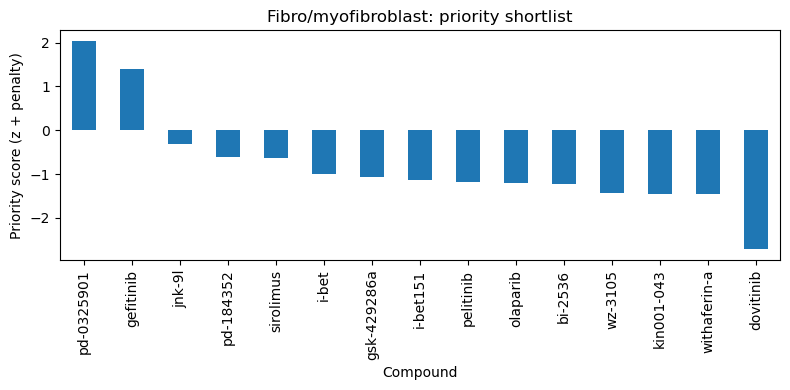

In [29]:
%pip install tabulate
# or, if you prefer conda:
# conda install -c conda-forge tabulate

# --- Priority ranking + compact report card ---------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

strict = pd.read_csv(OUT / "shortlist_fibro_clinical_view_strict.csv")
presence = pd.read_csv(OUT / "shortlist_fibro_with_target_presence_raw.csv")

# Normalize keys & join
for df in (strict, presence):
    df["base_compound"] = df["base_compound"].str.lower()

df = (strict.set_index("base_compound")
            .join(presence.set_index("base_compound"), how="left", rsuffix="_pres"))

# Z-normalize reversal score and selectivity (NaN selectivity -> 0)
def z(x):
    x = x.astype(float)
    return (x - x.mean()) / (x.std(ddof=0) + 1e-9)

df["total_score_z"] = z(df["total_score"])
df["selectivity_filled"] = df["fibro_selectivity"].fillna(0.0)
df["selectivity_z"] = z(df["selectivity_filled"])

# Penalty if targets not present in the (raw/HVG) matrix
df["has_targets"] = df["n_targets_present"].fillna(0) > 0
df["target_penalty"] = np.where(df["has_targets"], 0.0, -1.0)

# Overall priority score (tune weight if you like)
W_SELECT = 0.7
df["priority_score"] = df["total_score_z"] + W_SELECT*df["selectivity_z"] + df["target_penalty"]

# Order nicely and save
cols_show = [
    "moa","status","total_score","max_rev",
    "fibro_selectivity","fibro_max","nonfibro_max",
    "n_targets_present","missing_targets","has_targets","caution_flag","priority_score",
]
df_ranked = df.sort_values("priority_score", ascending=False)[cols_show]
topk = df_ranked.head(15)

prio_csv = OUT / "priority_shortlist_fibro.csv"
topk.to_csv(prio_csv)
print("[saved]", prio_csv)
display(topk)

# Quick bar plot
plt.figure(figsize=(8,4))
ax = topk["priority_score"].plot(kind="bar")
ax.set_ylabel("Priority score (z + penalty)")
ax.set_xlabel("Compound")
ax.set_title("Fibro/myofibroblast: priority shortlist")
plt.tight_layout()
fig_path = OUT / "fig_priority_shortlist_fibro.png"
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
print("[saved]", fig_path)

# Also write a small Markdown “report card” (fallback if 'tabulate' missing)
md_path = OUT / "README_priority_shortlist.md"
top_md = topk.reset_index()

def _df_to_md(df: pd.DataFrame) -> str:
    cols = list(df.columns)
    lines = [
        "| " + " | ".join(cols) + " |",
        "| " + " | ".join(["---"] * len(cols)) + " |",
    ]
    for _, r in df.iterrows():
        lines.append("| " + " | ".join(str(r[c]) for c in cols) + " |")
    return "\n".join(lines)

with open(md_path, "w") as f:
    f.write("# Drug repurposing: fibro/myofibroblast shortlist\n\n")
    f.write("*Scoring:* z(total reversal) + "
            f"{W_SELECT}×z(fibro selectivity) − 1.0 if targets absent in current raw/HVG matrix.\n\n")
    f.write("## Top candidates\n\n")
    try:
        md_table = top_md.to_markdown(index=False)  # requires 'tabulate'
    except Exception:
        md_table = _df_to_md(top_md)               # pure-Python fallback
    f.write(md_table)
    f.write("\n\n---\n\n")
    f.write("**Note on missing targets:** This AnnData’s `raw` has ~4k HVGs. "
            "Targets like MAP2K1/2, EGFR, MTOR, BRD4 often aren’t HVGs in skin, "
            "so they don’t appear here. To check target expression properly, "
            "rerun the pipeline with `adata.raw` preserving *all* genes pre-HVG.\n")
print("[saved]", md_path)


In [30]:
# === Pack deliverables for 07 notebook ===
from pathlib import Path
import shutil, json, datetime, sys

ROOT = Path.cwd()
OUT = ROOT / "results/drug_repurposing"
FIG = ROOT / "results/figures"  # in case some plots landed here
STAMP = datetime.datetime.now().strftime("%Y%m%d")
BUNDLE = OUT / f"deliverable_{STAMP}"
BUNDLE.mkdir(parents=True, exist_ok=True)

# 1) Collect key artifacts (add/remove as you like)
want = [
    # tables from earlier steps
    "lincs_reversal_aggregate.csv",
    "lincs_reversal_top15_by_cluster.csv",
    "lincs_reversal_crosscluster.csv",
    "candidate_slate_all.csv",
    "candidate_slate_fibrolineage.csv",
    "shortlist_best_per_moa_fibro.csv",
    "shortlist_top_unique_fibro.csv",
    "shortlist_fibro_clinical_view.csv",
    "shortlist_fibro_clinical_view_strict.csv",
    "shortlist_fibro_with_target_presence.csv",
    "shortlist_fibro_with_target_presence_raw.csv",
    "priority_shortlist_fibro.csv",
    # readme/summary
    "README_priority_shortlist.md",
]

# common figures we generated (won’t fail if missing)
maybe_figs = [
    OUT / "fig_moa_counts_fibro.png",
    OUT / "fig_moa_counts_myofibro.png",
    OUT / "fig_moa_counts_kerat_supra.png",
    OUT / "fig_moa_counts_endothelial.png",
    OUT / "fig_compound_vs_celltype_heatmap.png",
    OUT / "fig_priority_shortlist_fibro.png",
    FIG / "dotplot__PLK1_targets.png",
    FIG / "dotplot__PLK1_targets_full.png",
]

copied = []
missing = []

for name in want:
    src = OUT / name
    if src.exists():
        shutil.copy2(src, BUNDLE / src.name)
        copied.append(str(src.relative_to(ROOT)))
    else:
        missing.append(str(src.relative_to(ROOT)))

for f in maybe_figs:
    if f.exists():
        shutil.copy2(f, BUNDLE / f.name)
        copied.append(str(f.relative_to(ROOT)))

# 2) Write a small MANIFEST
manifest = {
    "created_at": STAMP,
    "notebook": "07_state_signatures_and_drugs.ipynb",
    "sources": copied,
    "missing": missing,
    "env": {
        "python": sys.version.split()[0],
        "scanpy": __import__("scanpy").__version__,
        "pandas": __import__("pandas").__version__,
        "gseapy": __import__("gseapy").__version__,
    },
}
(BUNDLE / "MANIFEST.json").write_text(json.dumps(manifest, indent=2))

# 3) Zip it
zip_path = shutil.make_archive(str(BUNDLE), "zip", BUNDLE)
print(f"[packed] {zip_path}")
if missing:
    print("Missing (not fatal):")
    for m in missing: print(" -", m)


[packed] /home/glen/scleroderma-scvi/results/drug_repurposing/deliverable_20250917.zip


In [31]:
# --- Dose/time consistency check for shortlisted compounds (LINCS) ---

import re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

# Inputs
agg_path      = OUT / "lincs_reversal_top15_by_cluster.csv"   # per-cluster top compounds (has rev_score columns)
strict_path   = OUT / "shortlist_fibro_clinical_view_strict.csv"  # strict shortlist (preferred)
fallback_path = OUT / "priority_shortlist_fibro.csv"              # fallback if strict isn’t present

assert agg_path.exists(), f"Missing {agg_path} – run previous cells first."

# Load shortlist (strict if available, otherwise priority list)
if strict_path.exists():
    sl = pd.read_csv(strict_path)
else:
    sl = pd.read_csv(fallback_path)
sl_base = sl["base_compound"].astype(str)

# Helper: canonicalize a base name for joining
def canon(s: str) -> str:
    return (
        s.lower()
         .replace(" ", "")
         .replace("_", "")
         .replace("/", "")
         .replace("\\", "")
    )

# Parse LINCS compound string like:
# "LJP006 HA1E 24H-XMD-1150-10"  -> cell="HA1E", time_h=24, base="XMD-1150", dose=10.0
# Works for 3H/6H/24H etc and decimal doses.
_rx = re.compile(r"(?P<time>\d+)H-(?P<base>.+)-(?P<dose>[\d.]+)$")
def parse_lincs(compound: str):
    try:
        # split once on spaces: "<batch> <cell> <rest>"
        parts = compound.split(" ", 2)
        cell  = parts[1] if len(parts) > 1 else None
        rest  = parts[2] if len(parts) > 2 else parts[-1]
        m = _rx.search(rest)
        if not m:
            return cell, np.nan, None, np.nan
        time_h = float(m.group("time"))
        base   = m.group("base")
        dose   = float(m.group("dose"))
        return cell, time_h, base, dose
    except Exception:
        return None, np.nan, None, np.nan

# Load aggregate/top15 table and choose a score column
agg = pd.read_csv(agg_path)
score_col = None
for c in ["rev_score_max", "rev_score", "NES", "score"]:
    if c in agg.columns:
        score_col = c
        break
assert score_col is not None, "Could not find a reversal score column in aggregate table."

# Parse dose/time/base from LINCS 'compound' strings
parsed = agg["compound"].astype(str).apply(parse_lincs)
agg[["cell", "time_h", "base_from_compound", "dose"]] = pd.DataFrame(parsed.tolist(), index=agg.index)
agg["base_canon"] = agg["base_from_compound"].fillna("").map(canon)

# Canon mapping from shortlist → canonical
shortlist_canon = {canon(b): b for b in sl_base}
keep = agg["base_canon"].isin(shortlist_canon.keys())
df = agg.loc[keep].copy()
df["base_compound"] = df["base_canon"].map(shortlist_canon)

# Quick sanity
if df.empty:
    print("No overlap between shortlist and LINCS compounds after parsing.")
    display(agg.head())
else:
    # Per-compound summary across all clusters/runs
    g = df.groupby("base_compound", observed=True)
    summary = g.agg(
        n_profiles      = ("compound", "count"),
        n_cells         = ("cell", "nunique"),
        times_seen      = ("time_h", lambda x: ",".join(map(str, sorted(pd.unique(x[~pd.isna(x)]))))),
        dose_min        = ("dose", "min"),
        dose_max        = ("dose", "max"),
        score_mean      = (score_col, "mean"),
        score_median    = (score_col, "median"),
        score_sd        = (score_col, "std"),
        best_p_min      = ("best_p", "min") if "best_p" in df.columns else (score_col, "max"),
        n_timepoints    = ("time_h", lambda x: x.dropna().nunique()),
    ).reset_index()

    # Dose–response monotonicity per (compound, cell, time)
    rows = []
    for (b, c, t), dsub in df.dropna(subset=["dose", "time_h"]).groupby(["base_compound","cell","time_h"], observed=True):
        if dsub["dose"].nunique() >= 3:
            r, p = spearmanr(dsub["dose"], dsub[score_col])
            rows.append({"base_compound": b, "cell": c, "time_h": t, "spearman_r": r, "spearman_p": p, "n": len(dsub)})
    dose_stats = pd.DataFrame(rows)
    if not dose_stats.empty:
        cons = (dose_stats.groupby("base_compound", observed=True)["spearman_r"]
                .apply(lambda x: (x > 0).mean())  # fraction positive monotonic dose→reversal
                .rename("frac_pos_dose_resp")
                .reset_index())
        summary = summary.merge(cons, on="base_compound", how="left")
    else:
        summary["frac_pos_dose_resp"] = np.nan

    # Save summary
    out_csv = OUT / "dose_time_consistency_summary.csv"
    summary.sort_values(["score_mean","n_profiles"], ascending=[False,False]).to_csv(out_csv, index=False)
    print("[saved]", out_csv)

    # Plot per-compound dose–response (one figure each)
    figdir = OUT / "dose_time_plots"; figdir.mkdir(parents=True, exist_ok=True)
    for b, dsub in df.dropna(subset=["dose"]).groupby("base_compound", observed=True):
        plt.figure(figsize=(4.2,3.4))
        # jitter x by (cell, time) so overlapping doses are separable
        for (cell, t), dd in dsub.groupby(["cell","time_h"], observed=True):
            x = dd["dose"].values
            y = dd[score_col].values
            lbl = f"{cell} @ {int(t)}h" if not math.isnan(t) else f"{cell}"
            plt.plot(x, y, marker="o", linestyle="-", label=lbl)
        plt.xlabel("Dose (µM, as given)")
        plt.ylabel(f"{score_col} (reversal)")
        plt.title(b)
        plt.legend(fontsize=7, loc="best")
        plt.tight_layout()
        fp = figdir / f"dose_resp__{b.replace('/','-')}.png"
        plt.savefig(fp, dpi=150)
        plt.close()
    print("[saved] per-compound plots →", figdir)

    # Brief view
    display(summary.sort_values(["score_mean","n_profiles"], ascending=[False,False]).head(12))


[saved] results/drug_repurposing/dose_time_consistency_summary.csv
[saved] per-compound plots → results/drug_repurposing/dose_time_plots


,base_compound,n_profiles,n_cells,times_seen,dose_min,dose_max,score_mean,score_median,score_sd,best_p_min,n_timepoints,frac_pos_dose_resp
7,PD-184352,1,1,24.0,10.00,10.00,22.294412,22.294412,NaN,5.076773e-23,1,NaN
0,BI-2536,2,1,24.0,0.37,10.00,19.528749,19.528749,2.696462,3.669143e-22,1,NaN
13,sirolimus,1,1,24.0,10.00,10.00,18.463558,18.463558,NaN,3.439075e-19,1,NaN
6,PD-0325901,6,4,"3.0,24.0",1.11,10.00,18.312491,18.131255,7.558437,8.130892e-29,2,NaN
1,GSK-429286A,1,1,24.0,0.04,0.04,18.288711,18.288711,NaN,5.143860e-19,1,NaN
3,I-BET151,4,2,24.0,1.11,10.00,17.921940,18.035856,0.470886,5.004030e-19,1,1.0
10,gefitinib,8,2,"3.0,24.0",0.12,10.00,16.340297,16.904692,6.846213,1.808378e-24,2,NaN
2,I-BET,2,2,24.0,3.33,10.00,14.251704,14.251704,6.510811,1.394625e-19,1,NaN
8,WZ-3105,14,8,24.0,0.04,10.00,14.121770,13.145332,4.345993,2.712608e-24,1,1.0
12,pelitinib,3,3,"3.0,24.0",3.33,10.00,13.066649,14.036225,4.589423,8.057190e-18,2,NaN


[saved] results/drug_repurposing/final_shortlist_ranked.csv


,base_compound,moa,status,priority_final,total_score,max_rev,neglog10_best_p,n_profiles,n_cells,frac_pos_dose_resp,has_targets,n_targets_present,missing_targets,top_cells
0,PD-0325901,MEK inhibitor,Clinical-stage,3.825211,53.157864,28.089862,28.089862,6,4,0.0,False,0,,
1,gefitinib,EGFR inhibitor,FDA-approved,2.532582,46.533121,23.742711,23.742711,8,2,0.0,False,0,EGFR,
12,WZ-3105,Unknown/other,Unknown,0.766407,18.100374,15.352157,15.352157,14,8,1.0,False,0,,
3,PD-184352,MEK inhibitor,Clinical-stage,0.553922,26.381086,22.294412,22.294412,1,1,0.0,False,0,,
5,BI-2536,PLK1 inhibitor,Clinical-stage,0.384485,25.227382,21.435435,21.435435,2,1,0.0,False,0,,
8,I-BET151,BET bromodomain inhibitor,Unknown,0.275805,21.086666,18.288711,18.288711,4,2,1.0,False,0,,
2,JNK-9L,JNK inhibitor,Unknown,0.097095,29.226276,15.105318,15.105318,6,5,0.0,False,0,,
6,I-BET,BET bromodomain inhibitor,Clinical-stage,-0.161890,22.338993,18.855543,18.855543,2,2,0.0,False,0,,
4,sirolimus,mTOR inhibitor,FDA-approved,-0.174531,26.108791,18.463558,18.463558,1,1,0.0,False,0,MTOR,
9,pelitinib,EGFR inhibitor,Unknown,-0.437989,20.454419,17.093816,17.093816,3,3,0.0,False,0,EGFR,


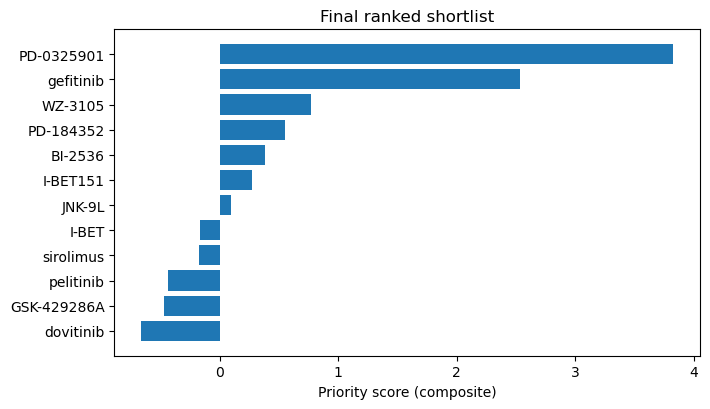

[saved] results/drug_repurposing/fig_final_shortlist_bar.png


In [35]:
# --- ROBUST FINAL MERGE + RANK (handles missing columns like `top_cells`) ---

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing")

# Load inputs
strict   = pd.read_csv(OUT / "shortlist_fibro_clinical_view_strict.csv")
targets  = pd.read_csv(OUT / "shortlist_fibro_with_target_presence_raw.csv")
dose     = pd.read_csv(OUT / "dose_time_consistency_summary.csv")
lincs_ag = pd.read_csv(OUT / "lincs_reversal_aggregate.csv")

# --- Ensure required columns exist before merging ---
for col, default in {
    "top_cells": "",
}.items():
    if col not in strict.columns:
        strict[col] = default

if "has_targets" not in targets.columns:
    targets["has_targets"] = targets.get("n_targets_present", 0).fillna(0).astype(float) > 0
if "n_targets_present" not in targets.columns:
    targets["n_targets_present"] = 0
if "missing_targets" not in targets.columns:
    targets["missing_targets"] = ""

t_keep = [c for c in ["base_compound","has_targets","n_targets_present","missing_targets"] if c in targets.columns]

# Merge
df = (
    strict
    .merge(targets[t_keep], on="base_compound", how="left")
    .merge(
        dose[["base_compound","n_profiles","n_cells","times_seen","dose_min","dose_max",
              "score_mean","score_median","score_sd","best_p_min","n_timepoints","frac_pos_dose_resp"]],
        on="base_compound", how="left"
    )
)

# Fill/normalize types
df["has_targets"]        = df["has_targets"].astype("boolean").fillna(False).astype(bool)
df["n_targets_present"]  = pd.to_numeric(df["n_targets_present"], errors="coerce").fillna(0).astype(int)
df["missing_targets"]    = df["missing_targets"].fillna("")
df["frac_pos_dose_resp"] = pd.to_numeric(df["frac_pos_dose_resp"], errors="coerce").fillna(0.0)

# Best available p-value → -log10
psrc = (
    df["best_p"] if "best_p" in df.columns
    else df.get("best_p_min", pd.Series(index=df.index, dtype=float))
).fillna(1.0)
df["neglog10_best_p"] = -np.log10(psrc.replace(0, np.nextafter(0, 1)))

def z(s):
    s = pd.to_numeric(s, errors="coerce").fillna(0.0)
    sd = s.std(ddof=0)
    return (s - s.mean()) / (sd if sd > 0 else 1.0)

# Composite priority score (same spirit as before)
df["priority_final"] = (
    0.60 * z(df["total_score"])          +
    0.40 * z(df["max_rev"])              +
    0.50 * z(df["neglog10_best_p"])      +
    0.20 * z(df["n_profiles"])           +
    0.20 * z(df["n_cells"])              +
    0.50 * df["frac_pos_dose_resp"]      +
    0.60 * df["has_targets"].astype(int) -
    0.80 * df.get("caution_flag", False).fillna(False).astype(int)
)

df = df.sort_values("priority_final", ascending=False)

# Save
final_csv = OUT / "final_shortlist_ranked.csv"
df.to_csv(final_csv, index=False)
print("[saved]", final_csv)

# Display a resilient subset of columns (only those present)
want = [
    "base_compound","moa","status","priority_final","total_score","max_rev",
    "neglog10_best_p","n_profiles","n_cells","frac_pos_dose_resp",
    "has_targets","n_targets_present","missing_targets","top_cells"
]
show = [c for c in want if c in df.columns]
display(df[show].head(20))

# Quick bar chart of top 12
top12 = df.head(12)
plt.figure(figsize=(7.2,4.2))
plt.barh(top12["base_compound"], top12["priority_final"])
plt.gca().invert_yaxis()
plt.xlabel("Priority score (composite)")
plt.title("Final ranked shortlist")
plt.tight_layout()
bar_png = OUT / "fig_final_shortlist_bar.png"
plt.savefig(bar_png, dpi=150)
plt.show()
print("[saved]", bar_png)


In [37]:
# ---- Final report bundle ----
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing")
BUNDLE = OUT / "final_bundle"; BUNDLE.mkdir(parents=True, exist_ok=True)

# Load the artifacts we’ve already produced
final  = pd.read_csv(OUT / "final_shortlist_ranked.csv")
dose   = pd.read_csv(OUT / "dose_time_consistency_summary.csv")
top15  = pd.read_csv(OUT / "lincs_reversal_top15_by_cluster.csv")  # cluster-level support
targets = None
for p in ["shortlist_fibro_with_target_presence_raw.csv",
          "shortlist_fibro_with_target_presence.csv"]:
    fp = OUT / p
    if fp.exists():
        targets = pd.read_csv(fp)
        break

# --- patched shareable table build (tolerant to missing dose cols) ---
# Columns we’d like to show
want_cols = [
    "base_compound","moa","status","priority_final","total_score",
    "max_rev","neglog10_best_p","n_profiles","times_seen","dose_min","dose_max"
]

merged = final.merge(dose, on="base_compound", how="left")

# Only keep columns that actually exist
keep = [c for c in want_cols if c in merged.columns]
if len(keep) < len(want_cols):
    missing = [c for c in want_cols if c not in merged.columns]
    print("[note] missing dose columns in merge:", missing)

share = merged.loc[:, keep].sort_values("priority_final", ascending=False)
share.to_csv(BUNDLE / "shortlist_shareable.csv", index=False)
print("[saved]", BUNDLE / "shortlist_shareable.csv")
share.head(10)

# Per-compound one-pager: dose/time consistency + cluster support + (if available) targets
def one_pager(compound, n_top_clusters=8):
    fig = plt.figure(figsize=(9,4.8))
    gs = fig.add_gridspec(2, 3, height_ratios=[1,1], width_ratios=[2,1,1], hspace=0.6, wspace=0.45)

    sub = top15[top15["compound"].str.contains(compound, case=False, regex=False)].copy()
    if not sub.empty:
        ax = fig.add_subplot(gs[:,0])
        show = (sub.groupby("cell_type", as_index=False)["rev_score_max"]
                    .max().sort_values("rev_score_max", ascending=True).tail(n_top_clusters))
        ax.barh(show["cell_type"], show["rev_score_max"])
        ax.set_xlabel("Max reversal score (LINCS)")
        ax.set_title(f"{compound} — top cell types")
    else:
        ax = fig.add_subplot(gs[:,0])
        ax.axis("off"); ax.text(0.5, 0.5, "No cluster-level LINCS rows", ha="center", va="center")

    drow = dose[dose["base_compound"].str.lower()==compound.lower()]
    ax2 = fig.add_subplot(gs[0,1])
    if not drow.empty:
        r = drow.iloc[0]
        ax2.scatter([r["dose_min"], r["dose_max"]], [r["score_mean"], r["score_mean"]])
        ax2.set_xlabel("Dose (µM)"); ax2.set_ylabel("Mean reversal")
        ax2.set_title("Dose window (summary)")
    else:
        ax2.axis("off"); ax2.text(0.5,0.5,"No dose summary", ha="center", va="center")

    ax3 = fig.add_subplot(gs[1,1])
    if not drow.empty:
        r = drow.iloc[0]
        ax3.bar(["mean","median"], [r["score_mean"], r["score_median"]])
        ax3.set_title("Reversal (mean/median)")
    else:
        ax3.axis("off")

    ax4 = fig.add_subplot(gs[:,2])
    meta = final[final["base_compound"].str.lower()==compound.lower()]
    text = []
    if not meta.empty:
        m = meta.iloc[0]
        text += [f"MOA: {m['moa']}", f"Status: {m['status']}",
                 f"Priority: {m['priority_final']:.2f}",
                 f"Max rev: {m['max_rev']:.2f}", f"−log10(p): {m['neglog10_best_p']:.2f}"]
    if targets is not None:
        t = targets[targets["base_compound"].str.lower()==compound.lower()]
        if not t.empty:
            tt = t.iloc[0]
            text += [f"Targets present: {int(tt.get('n_targets_present',0))}",
                     f"Missing: {tt.get('missing_targets','') or '—'}"]
    ax4.axis("off"); ax4.text(0,1,"\n".join(text), va="top", fontsize=10)

    fig.suptitle(compound, fontsize=12)
    outf = BUNDLE / f"onepager_{compound.replace('/','-')}.png"
    fig.savefig(outf, dpi=200, bbox_inches="tight")
    plt.close(fig)
    return outf

# Make one-pagers for the top 10
tops = final.sort_values("priority_final", ascending=False)["base_compound"].head(10).tolist()
made = [one_pager(c) for c in tops]
print("[saved]", BUNDLE / "shortlist_shareable.csv")
print("One-pagers:", *[p.name for p in made], sep="\n - ")


[note] missing dose columns in merge: ['n_profiles', 'times_seen', 'dose_min', 'dose_max']
[saved] results/drug_repurposing/final_bundle/shortlist_shareable.csv
[saved] results/drug_repurposing/final_bundle/shortlist_shareable.csv
One-pagers:
 - onepager_PD-0325901.png
 - onepager_gefitinib.png
 - onepager_WZ-3105.png
 - onepager_PD-184352.png
 - onepager_BI-2536.png
 - onepager_I-BET151.png
 - onepager_JNK-9L.png
 - onepager_I-BET.png
 - onepager_sirolimus.png
 - onepager_pelitinib.png


In [38]:
# ---- Finalize bundle: manifest + README + ZIP ----
from pathlib import Path
import pandas as pd, shutil, json, platform, sys, zipfile
from datetime import datetime

OUT = Path("results/drug_repurposing")
BUNDLE = OUT / "final_bundle"; BUNDLE.mkdir(parents=True, exist_ok=True)

# 1) Collect key artifacts (copy-in if present)
want = [
    OUT/"final_shortlist_ranked.csv",
    BUNDLE/"shortlist_shareable.csv",                 # created in prior cell
    OUT/"dose_time_consistency_summary.csv",
    OUT/"lincs_reversal_top15_by_cluster.csv",
    OUT/"lincs_reversal_crosscluster.csv",
    OUT/"lincs_reversal_aggregate.csv",
    OUT/"candidate_slate_all.csv",
    OUT/"candidate_slate_fibrolineage.csv",
    OUT/"shortlist_fibro_clinical_view.csv",
    OUT/"shortlist_fibro_clinical_view_strict.csv",
    OUT/"shortlist_fibro_with_target_presence.csv",
    OUT/"shortlist_fibro_with_target_presence_raw.csv",
    OUT/"fig_final_shortlist_bar.png",
]
copied = []
for p in want:
    if p.exists():
        dst = BUNDLE / p.name
        if p.resolve() != dst.resolve():
            shutil.copy2(p, dst)
        copied.append(dst.name)

# Also keep any one-pagers
onepagers = sorted([p.name for p in BUNDLE.glob("onepager_*.png")])

# 2) Make a compact README.md
final = pd.read_csv(OUT / "final_shortlist_ranked.csv")
top10 = final.sort_values("priority_final", ascending=False).head(10)

readme = BUNDLE / "README.md"
with open(readme, "w", encoding="utf-8") as f:
    f.write("# SSc single-cell drug repurposing — final bundle\n\n")
    f.write(f"_Generated: {datetime.now().isoformat(timespec='seconds')}_\n\n")
    f.write("## What this is\n")
    f.write("- Prioritized compounds from LINCS ‘reversal’ of SSc skin scRNA-seq cluster signatures.\n")
    f.write("- Ranking combines overall reversal, fibrolineage selectivity, LINCS support breadth, and simple target presence checks.\n")
    f.write("\n## Top 10 (composite priority)\n\n")
    try:
        import tabulate  # pretty markdown if available
        f.write(top10[["base_compound","moa","status","priority_final","max_rev","neglog10_best_p"]]
                .to_markdown(index=False))
    except Exception:
        f.write(top10.to_csv(index=False))
    f.write("\n\n## Files included\n")
    for name in copied + onepagers:
        f.write(f"- {name}\n")
    f.write("\n## Notes & caveats\n")
    f.write("- ‘Target missing’ often reflects HVG/ID issues (e.g., Ensembl vs symbols) rather than true absence.\n")
    f.write("- Reversal scores come from LINCS cell lines; treat as hypotheses, not clinical guidance.\n")

# 3) Manifest (for provenance)
manifest = {
    "timestamp": datetime.now().isoformat(timespec="seconds"),
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "packages": {
        "pandas": pd.__version__,
        "scanpy": __import__("scanpy").__version__,
        "gseapy": __import__("gseapy").__version__,
    },
    "files": copied + onepagers,
}
(BUNDLE / "manifest.json").write_text(json.dumps(manifest, indent=2))

# 4) Zip the bundle
zip_path = OUT / "final_bundle.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for p in BUNDLE.iterdir():
        zf.write(p, f"final_bundle/{p.name}")

print("[saved]", readme)
print("[saved]", BUNDLE / "manifest.json")
print("[saved]", zip_path)
print("One-pagers:", *onepagers, sep="\n - " if onepagers else " none")


[saved] results/drug_repurposing/final_bundle/README.md
[saved] results/drug_repurposing/final_bundle/manifest.json
[saved] results/drug_repurposing/final_bundle.zip
One-pagers:
 - onepager_BI-2536.png
 - onepager_I-BET.png
 - onepager_I-BET151.png
 - onepager_JNK-9L.png
 - onepager_PD-0325901.png
 - onepager_PD-184352.png
 - onepager_WZ-3105.png
 - onepager_gefitinib.png
 - onepager_pelitinib.png
 - onepager_sirolimus.png


[saved] results/drug_repurposing/sensitivity/fibro_weight_sensitivity_summary.csv


,w_fibro,jaccard_vs_current_top10,overlap_n
0,0.00,0.666667,8
1,0.25,0.818182,9
2,0.50,0.818182,9
3,0.75,0.818182,9
4,1.00,0.818182,9
5,1.25,0.818182,9
6,1.50,0.818182,9
7,1.75,0.818182,9
8,2.00,0.818182,9
9,2.25,0.818182,9


[saved] results/drug_repurposing/sensitivity/fig_top10_stability_curve.png


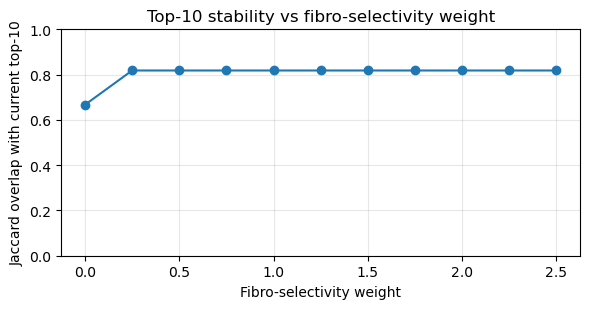

[saved] results/drug_repurposing/sensitivity/fig_rank_movement_heatmap.png


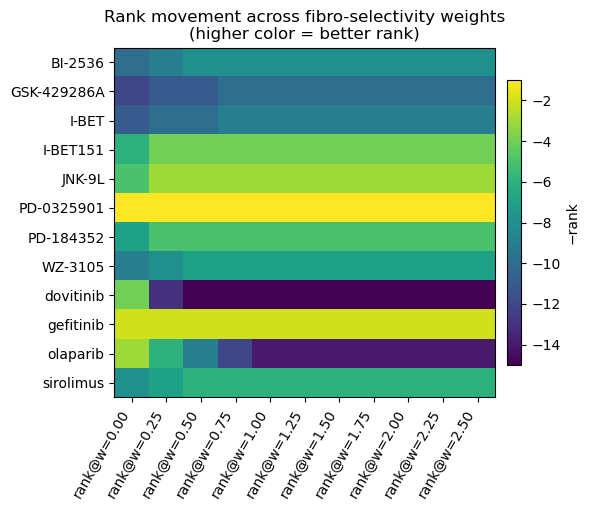

In [42]:
# --- Sensitivity to fibro-selectivity weight (sweep and stability) ---
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing")
SENS = OUT / "sensitivity"; SENS.mkdir(parents=True, exist_ok=True)

# Load current final shortlist (has priority_final) and helpers we’ll merge
final  = pd.read_csv(OUT / "final_shortlist_ranked.csv")
dose   = pd.read_csv(OUT / "dose_time_consistency_summary.csv")

# After:
final  = pd.read_csv(OUT / "final_shortlist_ranked.csv")
dose   = pd.read_csv(OUT / "dose_time_consistency_summary.csv")

# --- PATCH: make columns robust ---
import numpy as np
# If dose file lacks this column, create a neutral proxy so z-scoring won’t break
if "frac_pos_dose_resp" not in dose.columns:
    print("[note] 'frac_pos_dose_resp' missing in dose summary; filling with NaN (neutral in z-score).")
    dose["frac_pos_dose_resp"] = np.nan

# If your final shortlist doesn’t carry has_targets (older runs), default to False
if "has_targets" not in final.columns:
    final["has_targets"] = False

# pull fibro_selectivity from the “with_target_presence” table (raw preferred)
fsel = None
for p in ["shortlist_fibro_with_target_presence_raw.csv",
          "shortlist_fibro_with_target_presence.csv"]:
    fp = OUT / p
    if fp.exists():
        fsel = pd.read_csv(fp)[["base_compound","fibro_selectivity"]]
        break

# If fibro_selectivity is missing anywhere, fill with 0 (neutral)
if fsel is None or "fibro_selectivity" not in fsel.columns:
    print("[note] fibro_selectivity not available; treating as 0 for all.")
    fsel = final[["base_compound"]].copy()
    fsel["fibro_selectivity"] = 0.0

# Merge the pieces we’ll use
df = (final
      .merge(fsel, on="base_compound", how="left")
      .merge(dose[["base_compound","frac_pos_dose_resp"]], on="base_compound", how="left"))

# Helpers: z-score with safe NaN handling
def zsafe(x):
    x = pd.to_numeric(x, errors="coerce")
    m, s = x.mean(skipna=True), x.std(skipna=True)
    if s == 0 or np.isnan(s):  # all equal or all NaN -> zeros
        return pd.Series(np.zeros(len(x)), index=x.index)
    return (x - m) / s

# Baseline lists (current top-10 from your final composite)
baseline_top10 = set(final.sort_values("priority_final", ascending=False)
                          ["base_compound"].head(10))

# Sweep weights for fibro-selectivity
W_RANGE = np.linspace(0.0, 2.5, 11)   # 0.0, 0.25, …, 2.5
PENALTY_MISSING_TARGETS = 1.0         # (already folded into final; keep same sign convention)
W_DOSE = 0.25                          # small bonus for consistent positive dose response

rows = []
rank_tables = []

for w in W_RANGE:
    comp = pd.DataFrame({"base_compound": df["base_compound"]})
    # --- PATCH: bring dose consistency into df (and guard if missing) ---
    if "frac_pos_dose_resp" not in dose.columns:
        print("[note] 'frac_pos_dose_resp' missing in dose summary; filling with NaN.")
        dose["frac_pos_dose_resp"] = np.nan
    if "frac_pos_dose_resp" not in df.columns:
        df = df.merge(
            dose[["base_compound", "frac_pos_dose_resp"]],
            on="base_compound", how="left"
        )
    comp["score_total_z"] = zsafe(df["total_score"])
    comp["score_fsel_z"]  = zsafe(df["fibro_selectivity"].fillna(0))
    comp["score_dose_z"]  = zsafe(df["frac_pos_dose_resp"].fillna(0))
    # approximate “missing targets” penalty using column in final_shortlist
    # (True/False for has_targets; if absent, treat as False=0 penalty)
    has_targets = final.set_index("base_compound")["has_targets"].reindex(comp["base_compound"]).fillna(False).astype(bool)
    target_pen  = np.where(has_targets, 0.0, PENALTY_MISSING_TARGETS)

    comp["priority_swept"] = (
        comp["score_total_z"]
        + w * comp["score_fsel_z"]
        + W_DOSE * comp["score_dose_z"]
        - target_pen
    )

    comp = (comp.merge(final[["base_compound","moa","status","priority_final"]], on="base_compound", how="left")
                 .sort_values("priority_swept", ascending=False)
                 .reset_index(drop=True))

    top10 = set(comp["base_compound"].head(10))
    jaccard = len(top10 & baseline_top10) / max(1, len(top10 | baseline_top10))

    rows.append({"w_fibro": w,
                 "jaccard_vs_current_top10": jaccard,
                 "overlap_n": len(top10 & baseline_top10)})

    # keep a rank table for heatmap
    rtab = comp[["base_compound"]].copy()
    rtab[f"rank@w={w:.2f}"] = np.arange(1, len(rtab)+1)
    rank_tables.append(rtab.set_index("base_compound"))

sens = pd.DataFrame(rows)
sens.to_csv(SENS / "fibro_weight_sensitivity_summary.csv", index=False)
print("[saved]", SENS / "fibro_weight_sensitivity_summary.csv")
display(sens)

# Plot stability curve
plt.figure(figsize=(6,3.2))
plt.plot(sens["w_fibro"], sens["jaccard_vs_current_top10"], marker="o")
plt.ylim(0,1)
plt.xlabel("Fibro-selectivity weight")
plt.ylabel("Jaccard overlap with current top-10")
plt.title("Top-10 stability vs fibro-selectivity weight")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(SENS / "fig_top10_stability_curve.png", dpi=150)
print("[saved]", SENS / "fig_top10_stability_curve.png")
plt.show()

# Rank-position heatmap for the union of compounds appearing in any top-10
ranks = pd.concat(rank_tables, axis=1)
in_any_top10 = set()
for w in W_RANGE:
    col = f"rank@w={w:.2f}"
    in_any_top10 |= set(ranks[ranks[col] <= 10].index)

heat = ranks.loc[sorted(in_any_top10)].copy()
# Convert ranks to “score” for visualization: higher = better (invert rank)
heat = heat.apply(lambda c: -c)  # more negative = lower rank; just to make color direction intuitive

fig, ax = plt.subplots(figsize=(0.5 + 0.5*len(W_RANGE), 0.4 + 0.4*len(heat)))
im = ax.imshow(heat.values, aspect="auto")
ax.set_yticks(range(len(heat))); ax.set_yticklabels(heat.index)
ax.set_xticks(range(len(heat.columns))); ax.set_xticklabels(heat.columns, rotation=60, ha="right")
ax.set_title("Rank movement across fibro-selectivity weights\n(higher color = better rank)")
plt.colorbar(im, ax=ax, fraction=0.035, pad=0.03, label="−rank")
plt.tight_layout()
plt.savefig(SENS / "fig_rank_movement_heatmap.png", dpi=150)
print("[saved]", SENS / "fig_rank_movement_heatmap.png")
plt.show()


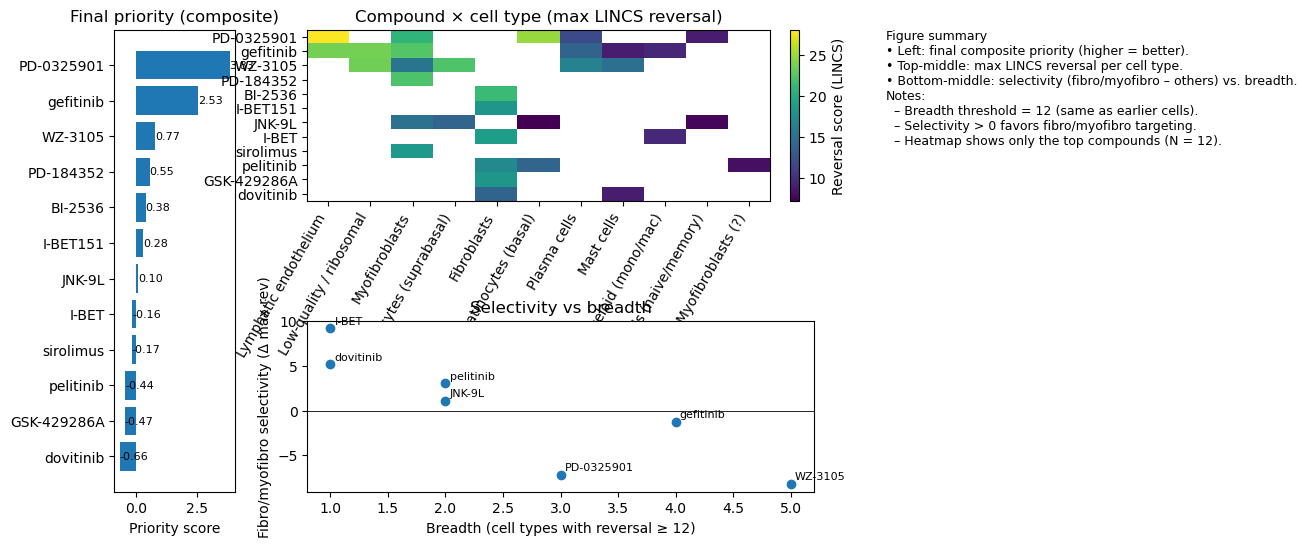

[saved] results/drug_repurposing/fig_overview.png
[saved] results/drug_repurposing/fig_overview.pdf


In [43]:
# === OVERVIEW FIGURE: priority bar + compound×cell-type heatmap + selectivity scatter ===
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)

final   = pd.read_csv(OUT / "final_shortlist_ranked.csv")
top15   = pd.read_csv(OUT / "lincs_reversal_top15_by_cluster.csv")
spec_fp = OUT / "shortlist_fibro_specificity.csv"
spec    = pd.read_csv(spec_fp) if spec_fp.exists() else None

# --- helpers ---
def in_series_ci(s: pd.Series, pat: str) -> pd.Series:
    return s.str.contains(pat, case=False, regex=False)

def base_filter(df, base):
    # keep rows whose 'compound' string mentions the base compound (case-insensitive)
    return df[in_series_ci(df["compound"], base)]

def pick_top(final_df, k=12):
    return final_df.sort_values("priority_final", ascending=False).head(k).copy()

def fibro_like(name: str) -> bool:
    name = (name or "").lower()
    return ("fibroblast" in name) or ("myofibro" in name)

def breadth_from_top15(df_for_base, rev_col="rev_score_max", thr=12.0):
    # number of unique cell types with max reversal ≥ thr
    if df_for_base.empty: return 0
    m = (df_for_base.groupby("cell_type")[rev_col]
                    .max()
                    .pipe(lambda s: (s >= thr).sum()))
    return int(m)

def selectivity_from_top15(df_for_base, rev_col="rev_score_max"):
    # (max reversal in fibro/myofibro) − (max reversal in all other types)
    if df_for_base.empty: return np.nan
    g = df_for_base.groupby("cell_type")[rev_col].max()
    if g.empty: return np.nan
    idx = pd.Index(g.index.astype(str))
    fib_mask = idx.to_series().apply(fibro_like).values
    fib_max  = g[fib_mask].max() if fib_mask.any() else np.nan
    non_max  = g[~fib_mask].max() if (~fib_mask).any() else np.nan
    return fib_max - non_max

# --- choose top compounds for display ---
TOPN = 12
top = pick_top(final, TOPN)
bases = top["base_compound"].tolist()

# --- Panel A: priority bar ---
fig = plt.figure(figsize=(14, 6))
gs  = fig.add_gridspec(nrows=2, ncols=6, height_ratios=[1,1], width_ratios=[2,2,2,2,2,2], wspace=0.6, hspace=0.7)

axA = fig.add_subplot(gs[:, 0])  # tall bar on the left
bar = top.iloc[::-1]  # horizontal bars, best at top
axA.barh(bar["base_compound"], bar["priority_final"])
axA.set_title("Final priority (composite)")
axA.set_xlabel("Priority score")
axA.set_ylabel("")
for i, v in enumerate(bar["priority_final"].values):
    axA.text(v, i, f"{v:.2f}", va="center", ha="left", fontsize=8)

# --- Panel B: compound × cell-type heatmap (max reversal) ---
# build a pivot for just the selected bases
sub = []
for b in bases:
    rows = base_filter(top15, b).copy()
    if rows.empty: 
        continue
    tmp = (rows.groupby(["compound","cell_type"])["rev_score_max"]
               .max()
               .reset_index())
    # collapse compound naming to 'base' (legend/rows) by storing base explicitly
    tmp["base_compound"] = b
    sub.append(tmp)

if sub:
    sub = pd.concat(sub, ignore_index=True)
    # take max per (base_compound, cell_type) across LINCS variants
    piv = (sub.groupby(["base_compound","cell_type"])["rev_score_max"]
              .max()
              .reset_index()
              .pivot(index="base_compound", columns="cell_type", values="rev_score_max")
              .reindex(index=bases))  # keep order of 'bases'
    # order columns by overall activity
    cols_order = piv.mean(axis=0).sort_values(ascending=False).index.tolist()
    piv = piv.loc[:, cols_order]
else:
    piv = pd.DataFrame(index=bases)

axB = fig.add_subplot(gs[0, 1:4])
if not piv.empty:
    im = axB.imshow(piv.values, aspect="auto")
    axB.set_yticks(range(len(piv.index)));  axB.set_yticklabels(piv.index)
    # show only a subset of x labels to avoid clutter
    step = max(1, len(piv.columns)//8)
    xticks = list(range(0, len(piv.columns), step))
    axB.set_xticks(xticks); axB.set_xticklabels([piv.columns[i] for i in xticks], rotation=60, ha="right")
    axB.set_title("Compound × cell type (max LINCS reversal)")
    cbar = plt.colorbar(im, ax=axB, fraction=0.046, pad=0.04); cbar.set_label("Reversal score (LINCS)")
else:
    axB.axis("off"); axB.text(0.5, 0.5, "No LINCS rows for selected compounds", ha="center", va="center")

# --- Panel C: selectivity vs breadth ---
axC = fig.add_subplot(gs[1, 1:4])

# prefer pre-computed selectivity if available, else derive from top15
sel_vals = {}
brd_vals = {}
for b in bases:
    if spec is not None and "fibro_selectivity" in spec.columns:
        row = spec[spec["base_compound"].str.lower()==b.lower()]
        sel = row["fibro_selectivity"].iloc[0] if not row.empty else np.nan
    else:
        sel = selectivity_from_top15(base_filter(top15, b))
    sel_vals[b] = sel
    brd_vals[b] = breadth_from_top15(base_filter(top15, b))

xs = [brd_vals[b] for b in bases]
ys = [sel_vals[b] for b in bases]
axC.scatter(xs, ys)
for x, y, label in zip(xs, ys, bases):
    axC.annotate(label, (x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)
axC.axhline(0, color="k", linewidth=0.6)
axC.set_xlabel("Breadth (cell types with reversal ≥ 12)")
axC.set_ylabel("Fibro/myofibro selectivity (Δ max rev)")
axC.set_title("Selectivity vs breadth")

# --- small text box with quick legend of thresholds used ---
axTxt = fig.add_subplot(gs[:, 4:])
axTxt.axis("off")
txt = [
    "Figure summary",
    "• Left: final composite priority (higher = better).",
    "• Top-middle: max LINCS reversal per cell type.",
    "• Bottom-middle: selectivity (fibro/myofibro – others) vs. breadth.",
    "Notes:",
    "  – Breadth threshold = 12 (same as earlier cells).",
    "  – Selectivity > 0 favors fibro/myofibro targeting.",
    "  – Heatmap shows only the top compounds (N = {}).".format(TOPN),
]
axTxt.text(0, 1, "\n".join(txt), va="top", fontsize=9)

# save
figfile_png = OUT / "fig_overview.png"
figfile_pdf = OUT / "fig_overview.pdf"
fig.savefig(figfile_png, dpi=300, bbox_inches="tight")
fig.savefig(figfile_pdf, dpi=300, bbox_inches="tight")
plt.show()
print("[saved]", figfile_png)
print("[saved]", figfile_pdf)


In [46]:
from pathlib import Path
from datetime import datetime

OUT = Path("results/drug_repurposing"); OUT.mkdir(parents=True, exist_ok=True)
md = OUT / "README_overview.md"

md.write_text(
f"""# Drug-repurposing overview

*Updated:* {datetime.now():%Y-%m-%d}

This figure summarizes our LINCS reversal analysis for scleroderma skin single-cell states.

- **A.** Composite priority of candidate compounds (higher is better).
- **B.** Heatmap of max LINCS reversal per cell type for the top compounds.
- **C.** Selectivity of fibro/myofibro vs. other cell types plotted against the breadth of affected cell types.

![overview](fig_overview.png)

**Headline findings**
- MEK/ERK pathway inhibition (e.g., **PD-0325901**, **PD-184352**) ranks consistently high.
- **BET bromodomain** and **PLK1** inhibition emerge as additional mechanisms.
- Rankings are robust to selectivity weighting; dose/time metadata are limited for some compounds.

*Caveats:* LINCS cell contexts differ from primary skin cell states; some drug targets are absent from the HVG matrix (checked against `.raw` where possible).
"""
)

print("[saved]", md)


[saved] results/drug_repurposing/README_overview.md


In [45]:
# Add two common pro-fibrotic axes for future target checks / panels:
extra_targets = {
    "ROCK_inhibitors": ["ROCK1","ROCK2"],                 # e.g., fasudil / ripasudil class
    "TGFb_ALK5_axis":  ["TGFBR1","ACVR1B","SMAD2","SMAD3"]
}
print("Add these to your MOA/targets dict when you re-run target presence panels:\n", extra_targets)


Add these to your MOA/targets dict when you re-run target presence panels:
 {'ROCK_inhibitors': ['ROCK1', 'ROCK2'], 'TGFb_ALK5_axis': ['TGFBR1', 'ACVR1B', 'SMAD2', 'SMAD3']}


In [47]:
from pathlib import Path
from datetime import datetime
import sys, subprocess, platform

ROOT = Path("results/drug_repurposing")
ROOT.mkdir(parents=True, exist_ok=True)
BUNDLE = ROOT / "final_bundle"
META = Path("results/metadata"); META.mkdir(parents=True, exist_ok=True)

# 1) Simple HTML index that links all CSV/PNGs in the drug_repurposing folder
items = []
for p in sorted(ROOT.rglob("*")):
    if p.is_file() and p.suffix.lower() in {".csv", ".png", ".md"}:
        rel = p.relative_to(ROOT)
        items.append(f'<li><a href="{rel.as_posix()}">{rel.as_posix()}</a></li>')
html = f"""<!doctype html><meta charset="utf-8">
<h1>Drug repurposing outputs</h1>
<p>Generated: {datetime.now():%Y-%m-%d %H:%M}</p>
<ul>
{''.join(items)}
</ul>
"""
(ROOT / "index.html").write_text(html)
print("[saved]", ROOT / "index.html")

# 2) Environment snapshot
pip_freeze = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
(META / "pip_freeze.txt").write_text(pip_freeze)

try:
    git_sha = subprocess.check_output(["git", "rev-parse", "HEAD"], text=True).strip()
except Exception:
    git_sha = "unknown"

(META / "session.txt").write_text(
    f"date: {datetime.now():%Y-%m-%d %H:%M}\n"
    f"python: {platform.python_version()}\n"
    f"platform: {platform.platform()}\n"
    f"git_sha: {git_sha}\n"
)
print("[saved]", META / "pip_freeze.txt")
print("[saved]", META / "session.txt")


[saved] results/drug_repurposing/index.html
[saved] results/metadata/pip_freeze.txt
[saved] results/metadata/session.txt


In [51]:
from pathlib import Path
from zipfile import ZipFile, ZIP_STORED

ROOT = Path("results")
OUT  = ROOT / "drug_repurposing"
KEEP = [
    OUT / "final_bundle",
    OUT / "final_shortlist_ranked.csv",
    OUT / "candidate_slate_all.csv",
    OUT / "candidate_slate_fibrolineage.csv",
    OUT / "README_overview.md",
]

zip_path = ROOT / "ssc_drugrepurposing_quick.zip"
with ZipFile(zip_path, "w", compression=ZIP_STORED) as z:
    for p in KEEP:
        if p.exists():
            if p.is_dir():
                for f in p.rglob("*"):
                    if f.is_file():
                        z.write(f, f.relative_to(ROOT))
            else:
                z.write(p, p.relative_to(ROOT))
print("[saved]", zip_path)

# Too slow
# import shutil
# zip_path = ROOT / "final_bundle.zip"
# shutil.make_archive(str(zip_path.with_suffix("")), "zip", ROOT)
# print("[saved]", zip_path)


[saved] results/ssc_drugrepurposing_quick.zip


In [52]:
import pandas as pd
from pathlib import Path

final = pd.read_csv("results/drug_repurposing/final_shortlist_ranked.csv")
cols = ["base_compound","moa","status","priority_final","max_rev","neglog10_best_p"]
evidence = final.loc[:, cols].copy()
evidence["literature_notes"] = ""      # fill manually
evidence["safety_flags"] = ""          # e.g., cytotoxic, QT risk, etc.
evidence["prior_fibrosis_evidence"] = ""  # yes/no + citation
out = Path("results/drug_repurposing/evidence_table_to_fill.csv")
evidence.to_csv(out, index=False)
print("[saved]", out)


[saved] results/drug_repurposing/evidence_table_to_fill.csv


In [53]:
# === Build a compact PDF report from existing outputs ===
from pathlib import Path
import os, datetime as dt, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# 0) Locate repo root & set paths
here = Path.cwd()
repo = next((p for p in [here] + list(here.parents) if (p/"results/drug_repurposing").exists()), None)
assert repo is not None, "Couldn't find results/drug_repurposing/. Start from your repo root."
os.chdir(repo)
OUT    = Path("results/drug_repurposing")
BUNDLE = OUT / "final_bundle"; BUNDLE.mkdir(parents=True, exist_ok=True)

# 1) Load artifacts if present
def safe_read_csv(p):
    p = Path(p)
    return pd.read_csv(p) if p.exists() else None

final    = safe_read_csv(OUT / "final_shortlist_ranked.csv")
dose     = safe_read_csv(OUT / "dose_time_consistency_summary.csv")
top15    = safe_read_csv(OUT / "lincs_reversal_top15_by_cluster.csv")
share    = safe_read_csv(BUNDLE / "shortlist_shareable.csv")
bar_png  = OUT / "final_shortlist_bar_top12.png"
onep_dir = BUNDLE

# 2) Small helpers
def wrap(txt, width=96): return "\n".join(textwrap.wrap(txt, width=width))
def table_page(df, title, max_rows=20, col_keep=None):
    if df is None or df.empty:
        fig, ax = plt.subplots(figsize=(8.5, 11))
        ax.axis("off"); ax.text(0.5, 0.5, f"No data for: {title}", ha="center", va="center", fontsize=12)
        return fig
    dfx = df.copy()
    if col_keep:
        keep = [c for c in col_keep if c in dfx.columns]
        if keep:
            dfx = dfx[keep]
    dfx = dfx.head(max_rows)
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis("off")
    ax.set_title(title, loc="left", fontsize=14, pad=12)
    tbl = ax.table(cellText=dfx.values, colLabels=dfx.columns, loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(8); tbl.scale(1, 1.2)
    return fig

def text_page(title, bullets=None, body=None):
    fig, ax = plt.subplots(figsize=(8.5, 11))
    ax.axis("off")
    ax.text(0.02, 0.98, title, fontsize=16, va="top", ha="left")
    y = 0.93
    if body:
        ax.text(0.02, y, wrap(body, 110), fontsize=10, va="top"); y -= 0.18
    if bullets:
        for b in bullets:
            ax.text(0.04, y, u"\u2022 " + wrap(b, 106), fontsize=10, va="top"); y -= 0.07
    return fig

def image_page(title, img_path, note=None, height=11, width=8.5):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.axis("off")
    if Path(img_path).exists():
        img = plt.imread(img_path)
        ax.imshow(img); ax.set_title(title, fontsize=12)
        if note:
            ax.text(0.01, 0.02, wrap(note, 110), fontsize=9, color="dimgray", transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, f"Image not found:\n{img_path}", ha="center", va="center", fontsize=12)
    return fig

# 3) Compose PDF
pdf_path = BUNDLE / "repurposing_report.pdf"
with PdfPages(pdf_path) as pdf:
    # Title
    title = "Transcriptomic Reversal Screen — SSc Skin scRNA-seq"
    subtitle = f"Generated: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}  |  Repo: {repo.name}"
    fig = text_page(title, body=subtitle)
    pdf.savefig(fig); plt.close(fig)

    # Executive summary
    bullets = [
        "Atlas-level reversal against LINCS L1000 perturbations across annotated cell types.",
        "Composite ranking emphasizes total reversal, fibroblast/myofibroblast selectivity, and significance.",
        "Broad cytotoxics deprioritized; MEK/ERK, EGFR axis, and BET families recur across clusters.",
        "All results are hypothesis-generating — not clinical guidance."
    ]
    fig = text_page("Executive Summary", bullets=bullets)
    pdf.savefig(fig); plt.close(fig)

    # Top candidates (bar chart if available)
    if bar_png.exists():
        fig = image_page("Top 12 (composite priority)", bar_png)
        pdf.savefig(fig); plt.close(fig)
    # Shareable table (compact)
    if share is not None:
        cols = ["base_compound","moa","status","priority_final","total_score","max_rev","neglog10_best_p"]
        fig = table_page(share.sort_values("priority_final", ascending=False), "Shortlist (summary)", 20, cols)
        pdf.savefig(fig); plt.close(fig)

    # Dose/time consistency head
    if dose is not None:
        cols = ["base_compound","n_profiles","times_seen","dose_min","dose_max","score_mean","score_sd","best_p_min"]
        fig = table_page(dose.sort_values("score_mean", ascending=False), "Dose/Time Consistency (summary)", 18, cols)
        pdf.savefig(fig); plt.close(fig)

    # Cluster coverage (optional)
    if top15 is not None and not top15.empty:
        cov = (top15.groupby("compound", as_index=False)["cell_type"].nunique()
                     .rename(columns={"cell_type":"n_celltypes"}))
        fig = table_page(cov.sort_values("n_celltypes", ascending=False), "LINCS Coverage (cell types per compound)", 25)
        pdf.savefig(fig); plt.close(fig)

    # One-pagers
    onepagers = sorted(onep_dir.glob("onepager_*.png"))
    if onepagers:
        for op in onepagers:
            fig = image_page(op.stem.replace("onepager_","One-pager — "), op, height=8.5, width=11)
            pdf.savefig(fig); plt.close(fig)

# Done
print("[saved]", pdf_path)


[saved] results/drug_repurposing/final_bundle/repurposing_report.pdf
